# 0.0. IMPORTS

## 0.1. Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pandas as pd
import numpy as np
import inflection
import datetime
import random
import math

from boruta                import BorutaPy
from tabulate              import tabulate
from matplotlib.gridspec   import GridSpec
from scipy                 import stats
from IPython.display       import Image

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

## 0.2. Helper Functions

### 0.2.1. Get Attributes

In [2]:
def get_numerical_attributes(data):
    return data.select_dtypes(include=['int32', 'int64', 'float32', 'float64'])

In [3]:
def get_categorical_attributes(data):
    return data.select_dtypes(exclude=['int32', 'int64', 'float32', 'float64', 'datetime64[ns]'])

### 0.2.2. Get Descriptive Info

In [4]:
def get_descriptive_info(data):
    num_attributes = get_numerical_attributes(data)

    # Central Tendency - mean, median
    df_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    df_median = pd.DataFrame(num_attributes.apply(np.median)).T

    # Dipersion - std, min, max, range, skew, kurtosis
    df_std = pd.DataFrame(num_attributes.apply(np.std)).T
    df_min = pd.DataFrame(num_attributes.apply(min)).T
    df_max = pd.DataFrame(num_attributes.apply(max)).T
    df_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    # min, max, range, mean, median, std, skew, kurtosis
    df_descriptive_info = pd.concat([df_min, df_max, df_range, 
                                     df_mean, df_median, df_std, 
                                     df_skew, df_kurtosis]).T.reset_index()

    df_descriptive_info.columns = ['attributes', 'min', 'max',
                                   'range', 'mean', 'median',
                                   'std', 'skew', 'kurtosis']
    
    return df_descriptive_info

### 0.2.3. Plot Numerical Distribution

In [5]:
def plot_numerical_distribution(data):
    num_attributes = get_numerical_attributes(data)

    num_rows = (len(num_attributes.columns) + 2) // 3
    num_cols = min(len(num_attributes.columns), 3)

    plt.figure(figsize=(15, 5 * num_rows))

    for i, column in enumerate(num_attributes.columns):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.hist(num_attributes[column], density=True, alpha=0.6, color='g')

        plt.title(f'Numerical Distribution Plot for {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

### 0.2.4. Plot Triangle Correlation Heatmap

In [6]:
def plot_triangle_correlation_heatmap(corr):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.set_theme(style='white')

    plt.figure(figsize=(30,10))
    heatmap = sns.heatmap(corr, 
                          mask=mask,
                          cmap='rocket_r', 
                          annot=True, 
                          linewidths=.5)

    heatmap.set_title('Triangle Correlation Heatmap', pad=16)

    plt.show()

### 0.2.5. Cramer V

In [7]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

### 0.2.6. Mean Absolute Percentage Error

In [8]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

### 0.2.7. Mean Percentage Error

In [9]:
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

### 0.2.8. Machine Learning Error1

In [10]:
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

### 0.2.9. Cross Validation

In [11]:
def cross_validation( x_training, model_name, model, kfold=5, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    
    for k in range(kfold, 0, -1):
        if verbose:
            print(f'\nKFold Number: {k}')
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # store performance of each KFold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


## 0.3. Loading Data

In [12]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRIPTION DATA

In [13]:
df1 = df_raw.copy()

In [14]:
df1.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
854344,1040,1,2013-05-27,13119,1172,1,1,0,0,a,a,4030.0,2.0,2013.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
600791,592,4,2014-01-09,5368,714,1,1,0,0,a,a,2540.0,6.0,2005.0,0,NaN,NaN,NaN
115052,208,7,2015-04-19,0,0,0,0,0,0,c,a,300.0,4.0,2006.0,0,NaN,NaN,NaN
143877,43,2,2015-03-24,5266,524,1,0,0,0,d,a,4880.0,NaN,NaN,1,37.0,2009.0,"Jan,Apr,Jul,Oct"
474733,529,5,2014-05-02,11323,1104,1,1,0,1,d,c,12920.0,9.0,2012.0,0,NaN,NaN,NaN


## 1.1. Rename Columns

In [15]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [16]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

sneakcase = lambda x: inflection.underscore(x)

cols_new = list(map(sneakcase, cols_old))

df1.columns = cols_new

## 1.2 Data Dimension

In [17]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [18]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [19]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [20]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [21]:
df1['competition_distance'].max()

75860.0

The 18 characteristics of the database, 6 contain missing data.

Currently, 100% of our database corresponds to 1,017,209 data. Of this total, for half, 3 characteristics have 508,031 as missing data, which corresponds to approximately 49.95% of the data.

In order to avoid the loss of many data, some manipulations were made to deal with these missing data. They are:

- **competition_distance**: The greatest distance so far was 75860.0, so all missing data were populated with a value of 200000.0.

- **competition_open_since_month**: I assign the corresponding month from the 'date' column to the missing values.

- **competition_open_since_year**: I assign the corresponding year from the 'date' column to the missing values.

- **promo2_since_week**: I assign the corresponding week from the 'date' column to the missing values.

- **promo2_since_year**: I assign the corresponding year from the 'date' column to the missing values.

- **promo_interval**: I assign the value 0 to the missing values and take advantage of this condition to create a new feature **'is_promo'** where I indicate whether there was a promotion in that store at a certain moment or not.

In [22]:
# competition_distance             
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week                               
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )


# promo2_since_year               
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dez',}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0  else  1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1  )

In [23]:
df1.sample( 5 ).T

,421299,883070,94328,1005401,49285
store,615,776,669,457,226
day_of_week,4,3,5,5,3
date,2014-06-19 00:00:00,2013-05-01 00:00:00,2015-05-08 00:00:00,2013-01-11 00:00:00,2015-06-17 00:00:00
sales,0,0,5081,4244,7913
customers,0,0,460,412,743
open,0,0,1,1,1
promo,1,1,1,1,1
state_holiday,a,a,0,0,0
school_holiday,0,0,0,0,0
store_type,d,c,d,d,a


In [24]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5. Change Data Types

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [27]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.6. Data Descriptive Info

In [28]:
get_descriptive_info(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


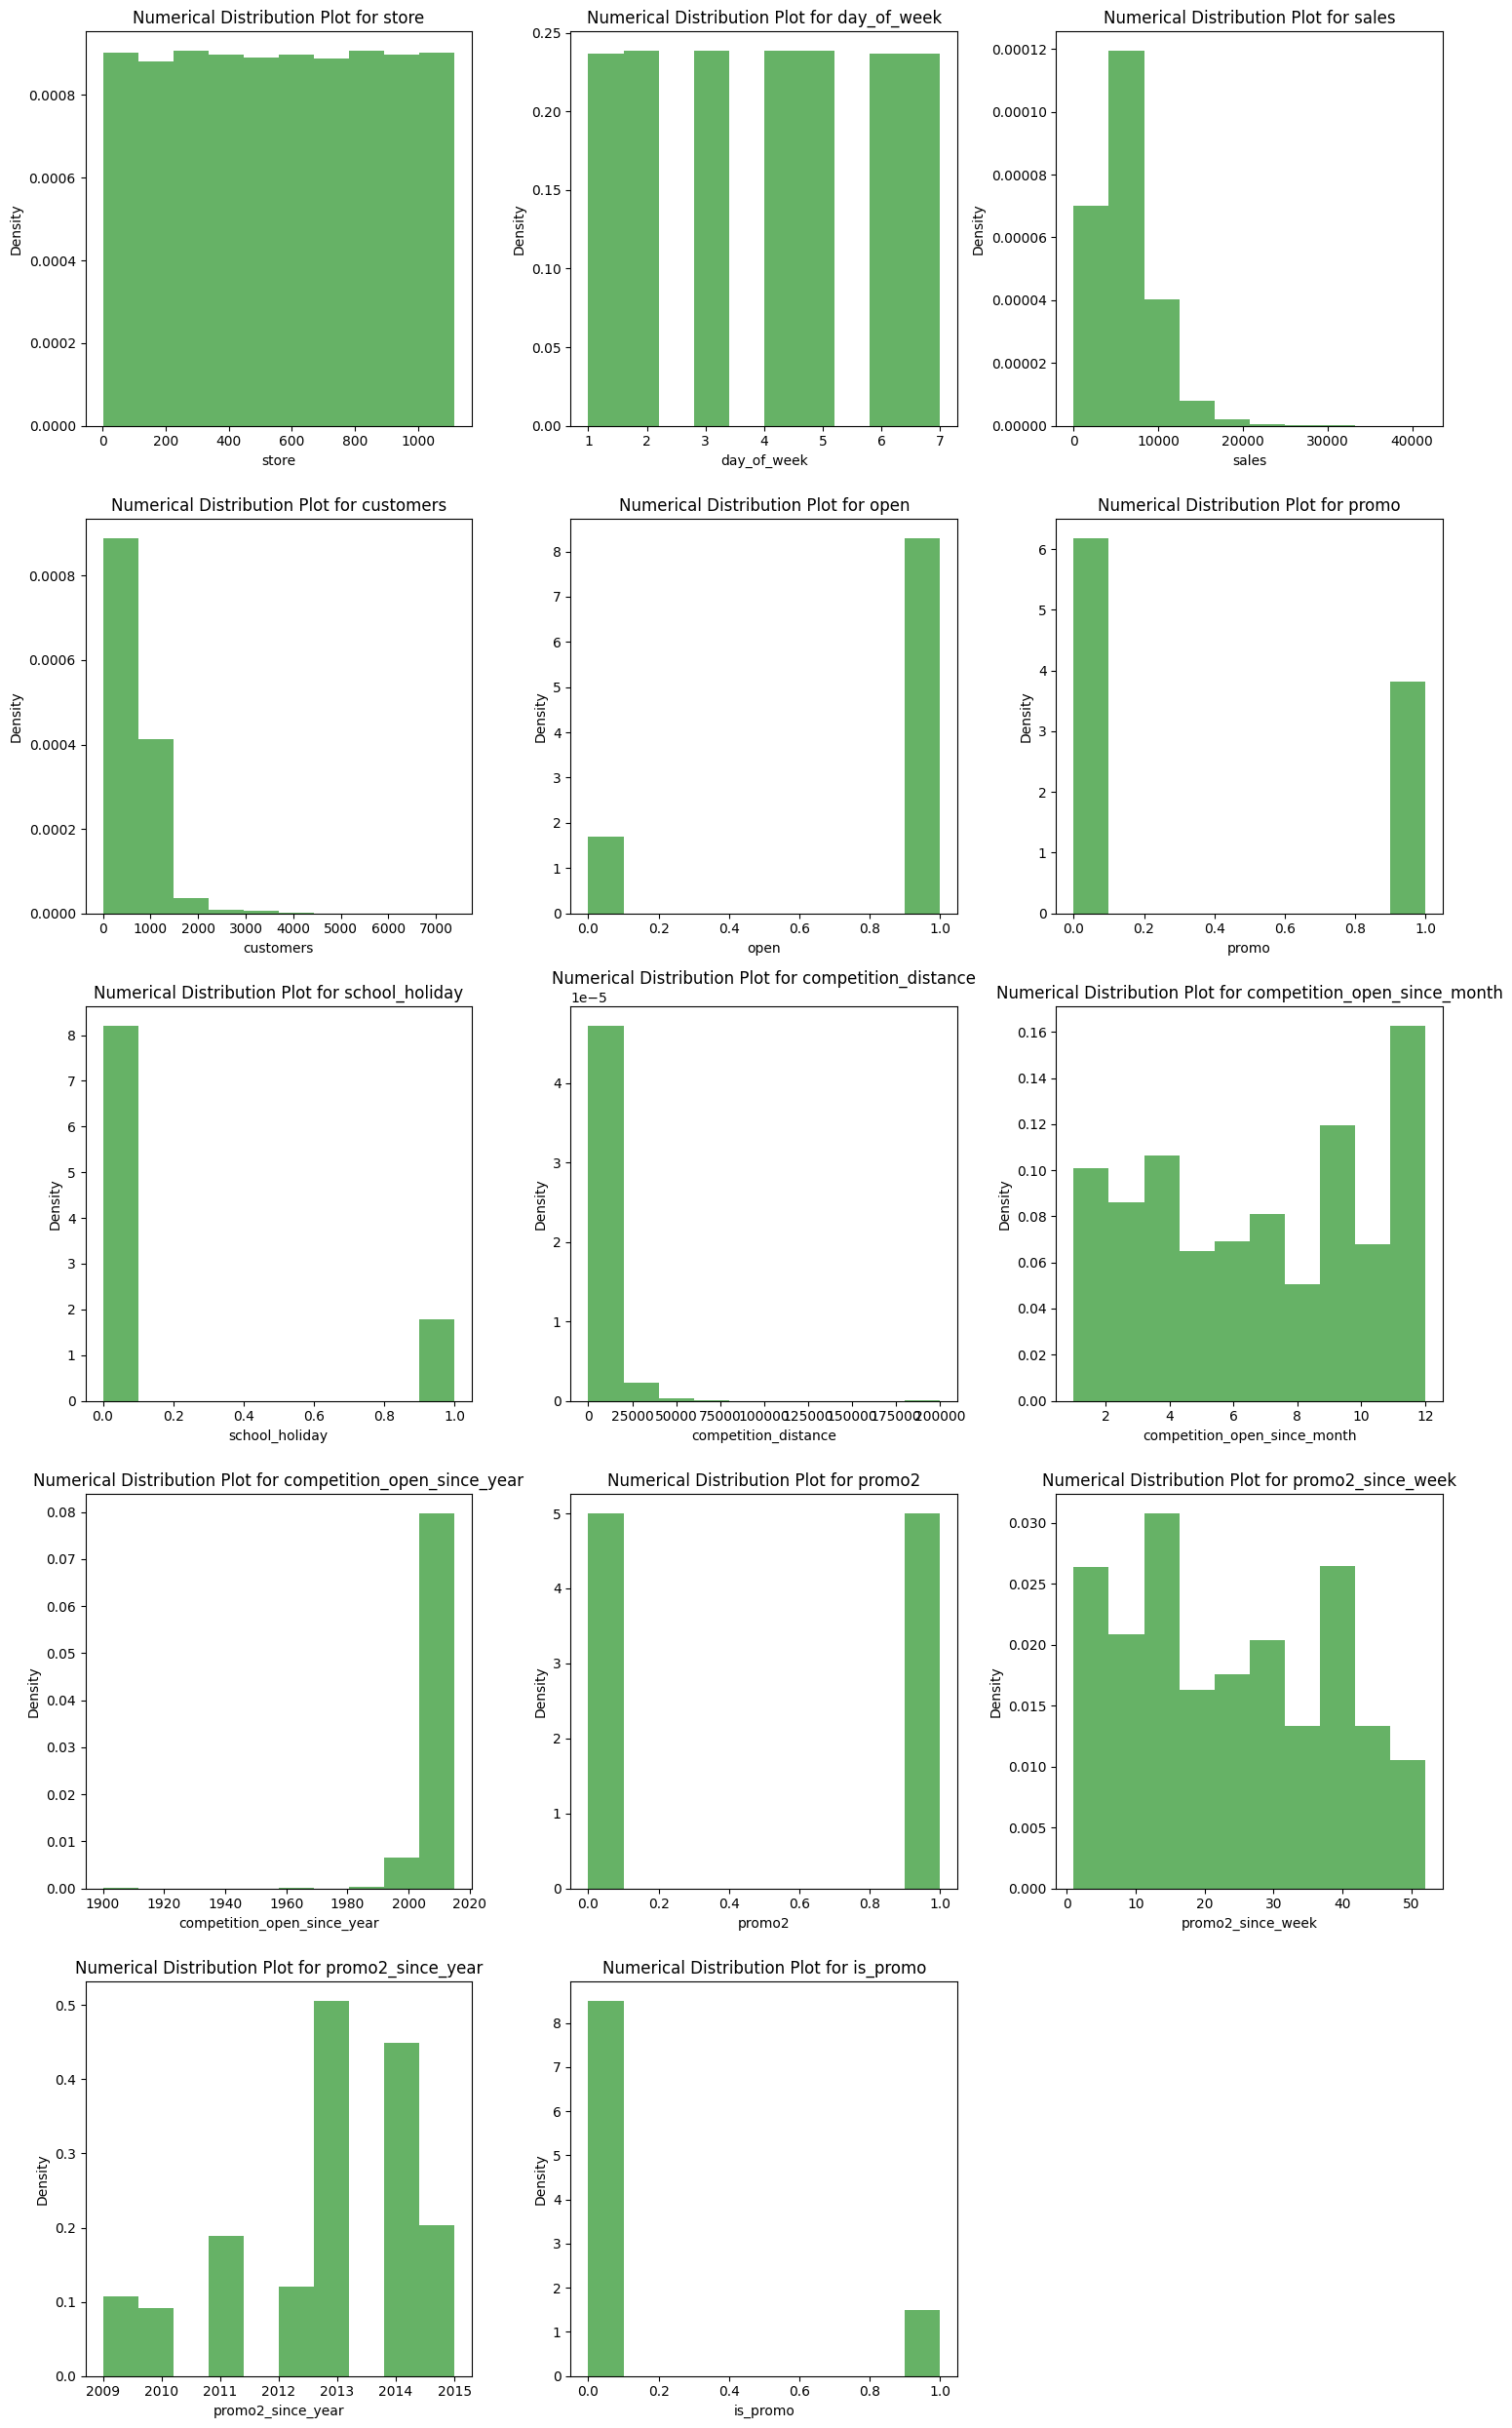

In [29]:
plot_numerical_distribution(df1)

## 1.7 Categorical Info

<Axes: xlabel='assortment', ylabel='sales'>

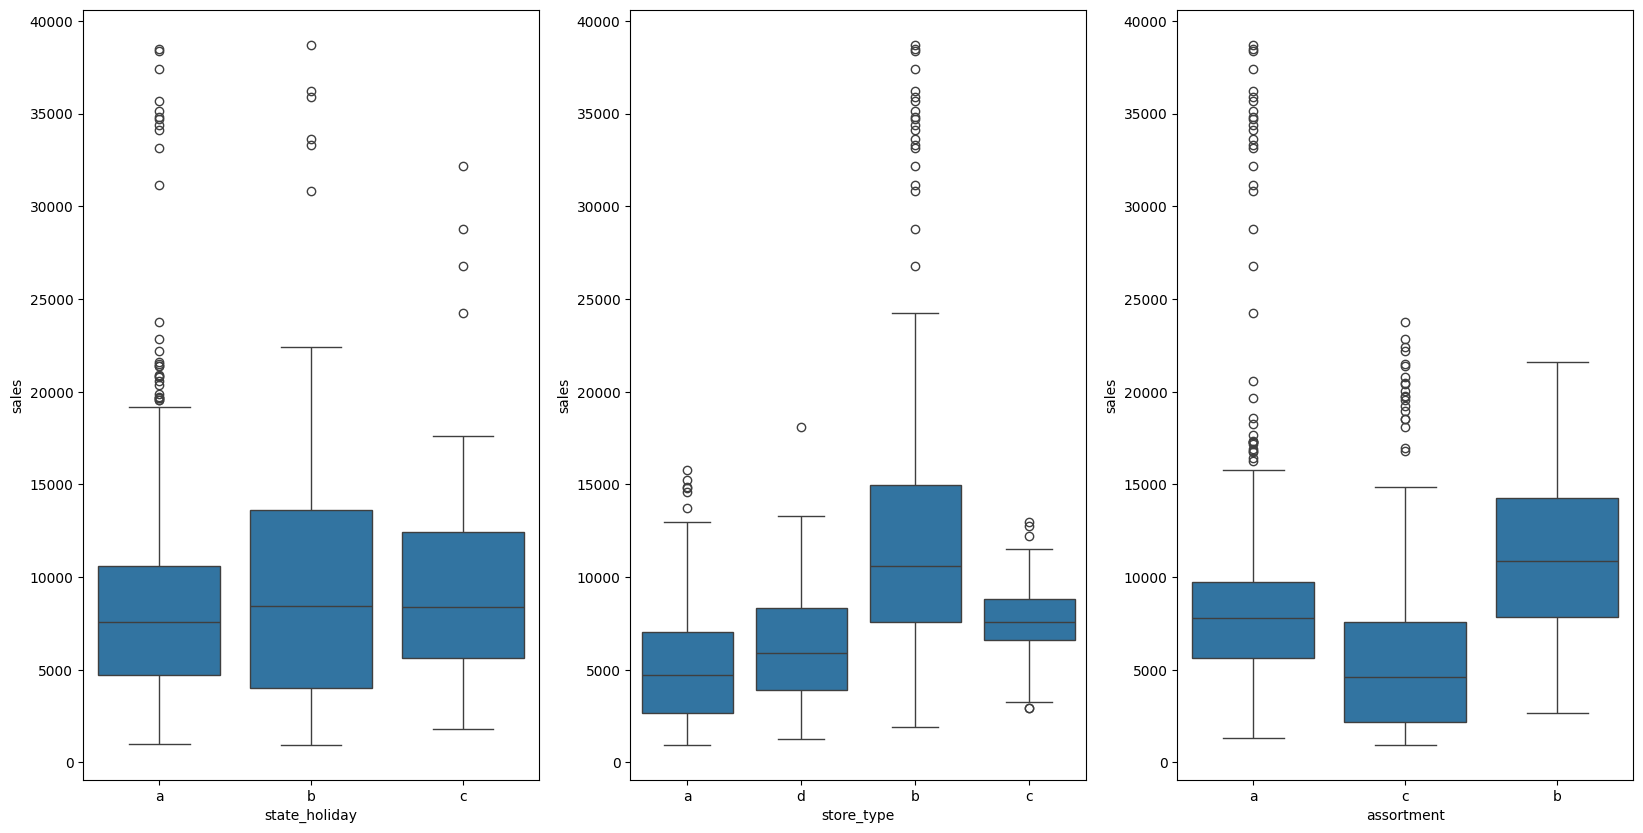

In [30]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1)

# 2.0. HYPOTHESE INSIGHTS

In [31]:
df2 = df1.copy()

In [32]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
31039,935,6,2015-07-04,3769,385,1,0,0,0,a,c,22350.0,6,2010,0,27,2015,0,Jul,0
567548,799,6,2014-02-08,10790,967,1,0,0,0,a,c,2700.0,2,2014,0,6,2014,0,Fev,0
827476,932,4,2013-06-20,7797,727,1,1,0,0,a,a,15700.0,6,2013,1,13,2010,"Jan,Apr,Jul,Oct",Jun,0
505933,509,5,2014-04-04,6843,555,1,1,0,0,a,a,4740.0,7,2008,1,37,2009,"Jan,Apr,Jul,Oct",Apr,1
866128,559,4,2013-05-16,6170,860,1,1,0,1,d,a,3910.0,11,2006,1,5,2013,"Feb,May,Aug,Nov",May,1


## 2.1. Mind Map Hypotheses

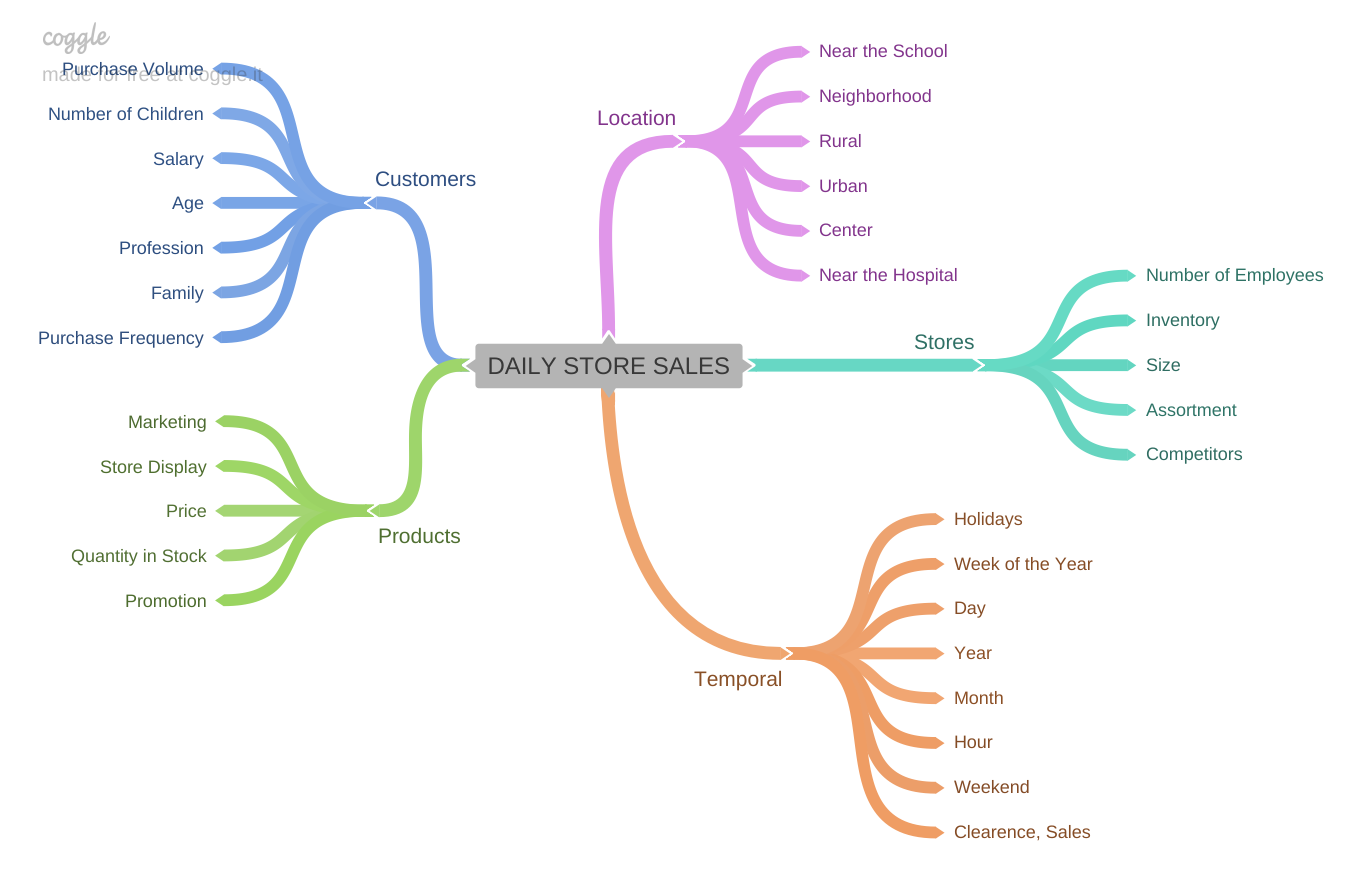

In [33]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypotheses Creation

### 2.2.1. Stores Hypotheses

**1.** Stores with a larger number of employees should sell more.

**2.** Stores with a greater stocking capacity should sell more.

**3.** Larger-sized stores should sell more.

**4.** Stores with a larger assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with competitors for a longer time should sell more.

### 2.2.2. Products Hypotheses

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with a larger product variety should sell more.

**3.** Stores with products at a lower price should sell more.

**4.** Stores with more aggressive discounts should sell more.

**5.** Stores with active promotions for a longer period should sell more.

**6.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions shoul sell more.

### 2.2.3. Time Hypotheses

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school periods.

## 2.3. Final List Hypotheses

**1.** Stores with a larger assortment should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with competitors for a longer time should sell more.

**4.** Stores with active promotions for a longer period should sell more.

**5.** Stores with more days of promotion should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school periods

# 3.0. FEATURE ENGINEERING

In [34]:
df3 = df2.copy()

In [35]:
df3.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
600177,1093,5,2014-01-10,9432,1011,1,1,0,0,c,c,10450.0,6,2009,0,2,2014,0,Jan,0
721217,598,1,2013-09-23,7200,914,1,1,0,0,c,a,550.0,12,2013,1,40,2014,"Jan,Apr,Jul,Oct",Sep,0
153259,505,1,2015-03-16,6629,749,1,1,0,0,a,a,350.0,3,2015,1,5,2013,"Feb,May,Aug,Nov",Mar,0
15160,666,6,2015-07-18,8012,812,1,0,0,0,c,c,2700.0,7,2015,1,9,2011,"Mar,Jun,Sept,Dec",Jul,0
670885,441,4,2013-11-07,5654,656,1,1,0,0,d,a,2530.0,11,2013,0,45,2013,0,Nov,0


With the purpose of better organizing the information contained in the data, I chose to create some new features with a temporal focus.

Self-explanatory Features:
- **year**
- **month**
- **day**
- **week_of_year**
- **year_week**

**competition_since**: represents the opening of the competition.

**competition_time_month**: calculates the difference in months between the date in the 'date' column and 'competition_since'.

**promo_since**: represents the start date of the promotion in the 'YYYY-WW' format to assist in creating promo_time_week.

**promo_time_week**: represents the difference in weeks between the date in the 'date' column and 'promo_since'.

**assortment**: Maps the values in the column to their original terms.

**state_holiday**: Maps the values in the column to their original terms.

In [36]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.isocalendar().week

# year week
df3['year_week'] = df3['date'].dt.strftime('%Y-%W')

# competition since
df3['competition_since'] = df3.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

df3['competition_time_month'] = ((df3['date'] - df3['competition_since']) /30).apply(lambda x: x.days).astype(int)

# promo since
df3['promo_since'] = df3['promo2_since_year'].astype(str) + '-' + df3['promo2_since_week'].astype(str)

df3['promo_since'] = df3['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))

df3['promo_time_week'] = ((df3['date'] - df3['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df3['assortment'] = df3['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df3['state_holiday'] = df3['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [37]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 4.0. VARIABLE FILTERING

In [38]:
df4 = df3.copy()

In [39]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 4.1. Rows Filtering

As the ultimate goal is to forecast sales, I chose to remove data from stores that were closed and stores that had not sold.

In [40]:
df4 = df4[(df4['open'] != 0) & (df4['sales'] > 0)]

In [41]:
df4.shape

(844338, 29)

## 4.2. Columns Selection

In [42]:
cols_drop =['customers', 'open', 'promo_interval', 'month_map']

In [43]:
df4 = df4.drop(cols_drop, axis=1)

In [44]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [45]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 5.0. EXPLORATORY DATA ANALYSIS

In [46]:
df5 = df4.copy()

In [47]:
df5.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
778560,1076,6,2013-08-03,2337,0,regular_day,0,a,extended,90.0,...,0,2013,8,3,31,2013-30,2013-08-01,0,2012-12-31,30
343587,745,1,2014-09-08,6279,0,regular_day,0,a,basic,17650.0,...,0,2014,9,8,37,2014-36,2013-11-01,10,2009-09-07,261
76949,15,6,2015-05-23,5333,0,regular_day,0,d,extended,4110.0,...,0,2015,5,23,21,2015-20,2010-03-01,63,2011-03-28,216
313848,957,5,2014-10-10,8654,1,regular_day,0,d,extended,1420.0,...,0,2014,10,10,41,2014-40,2012-11-01,23,2014-10-06,0
498109,490,5,2014-04-11,7789,0,regular_day,0,a,basic,660.0,...,1,2014,4,11,15,2014-14,2013-04-01,12,2014-09-29,-25


## 5.1. Univariate Analysis

### 5.1.1. Response Variable

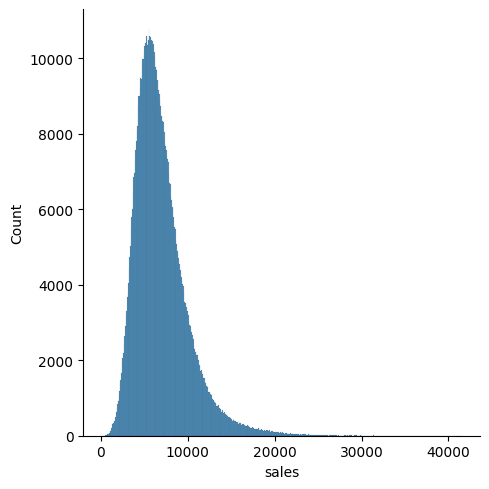

In [48]:
sns.displot(df5['sales'])

### 5.2.1. Numerical Variable

In [49]:
get_descriptive_info(df5)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


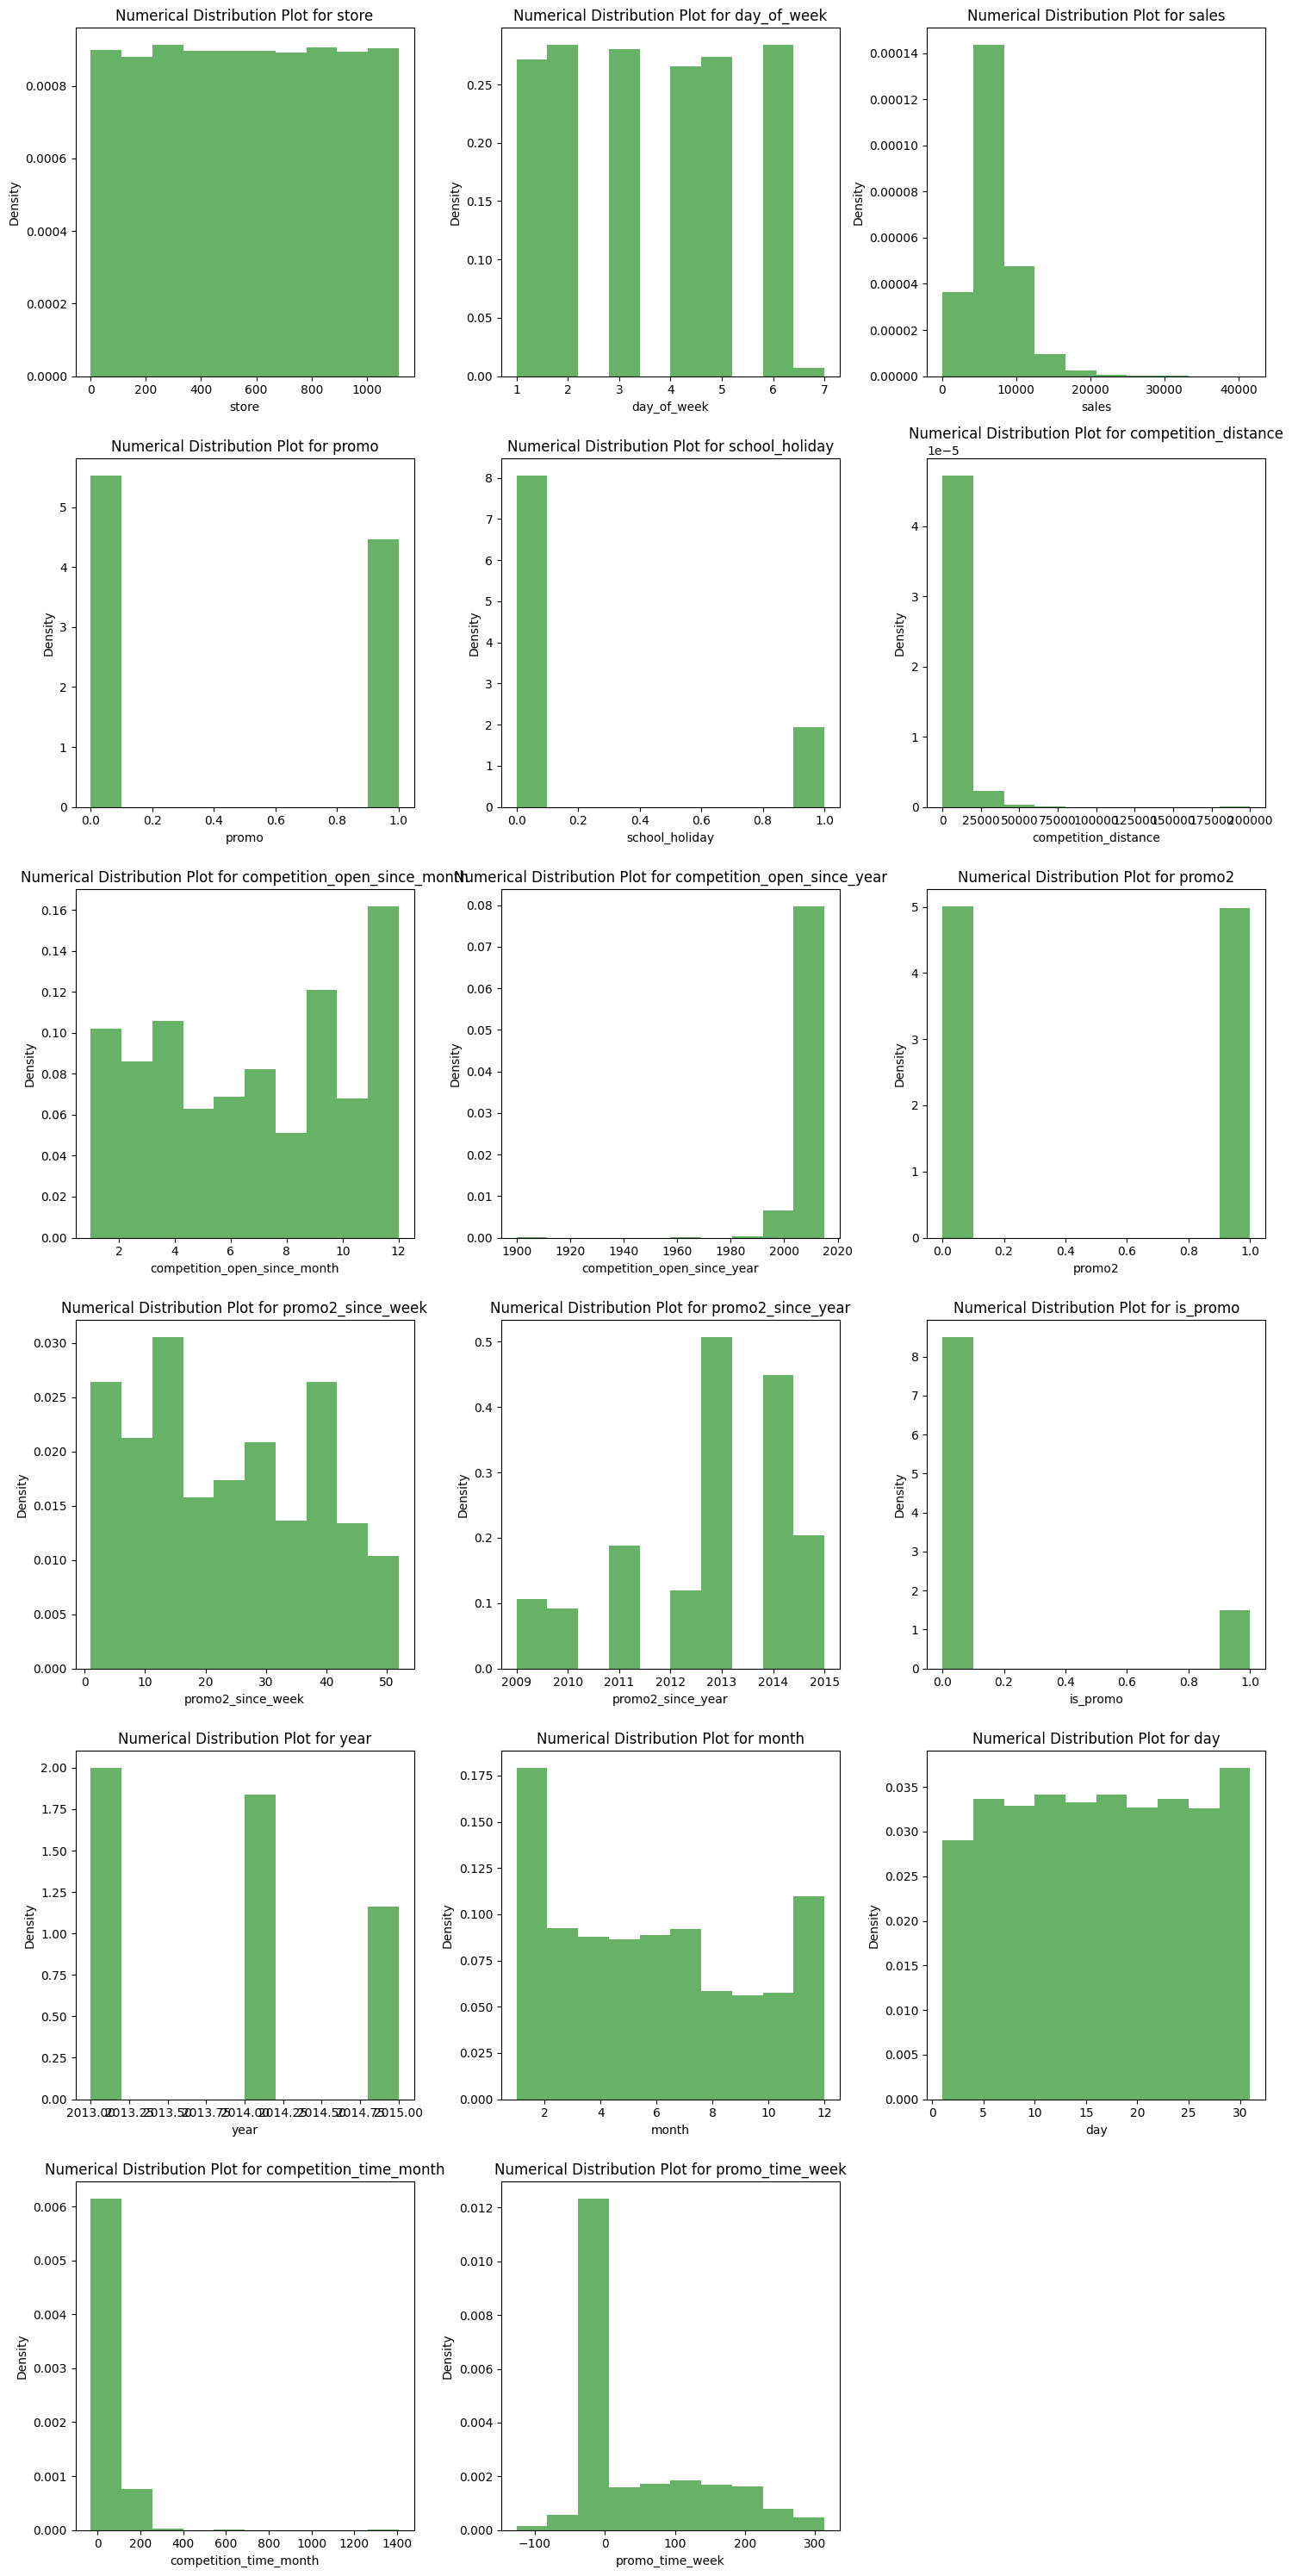

In [50]:
plot_numerical_distribution(df5)

### 5.3. Categorical Variable

In [51]:
cat_attributtes = get_categorical_attributes(df5)

In [52]:
cat_attributtes.columns

Index(['state_holiday', 'store_type', 'assortment', 'week_of_year',
       'year_week'],
      dtype='object')

In [53]:
df5['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [54]:
df5['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [55]:
df5['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<Axes: xlabel='count', ylabel='state_holiday'>

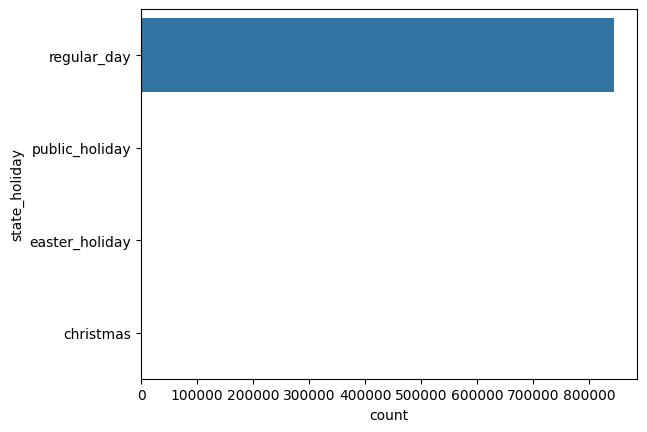

In [56]:
sns.countplot(df5['state_holiday'])

<Axes: xlabel='count', ylabel='state_holiday'>

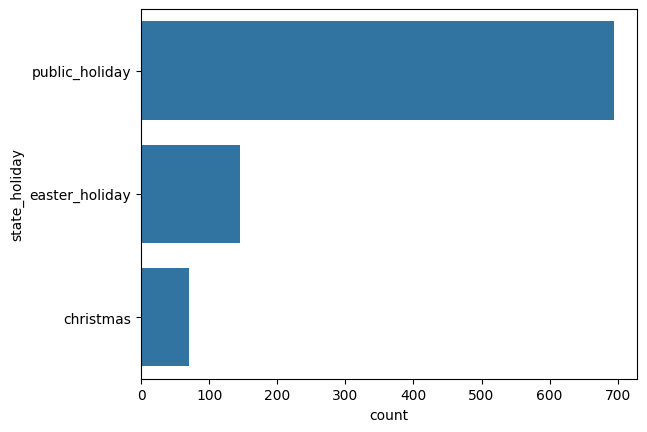

In [57]:
a = df5[df5['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

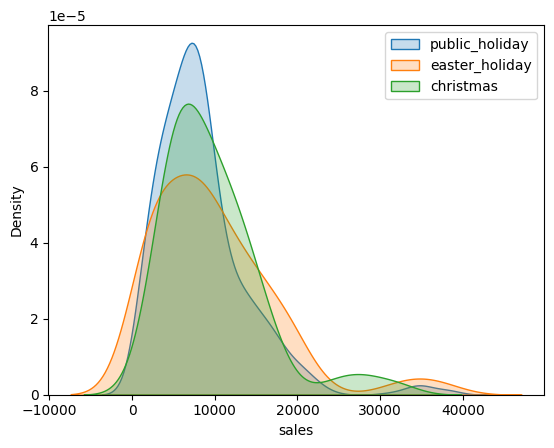

In [58]:
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)

sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)

sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)

plt.legend()

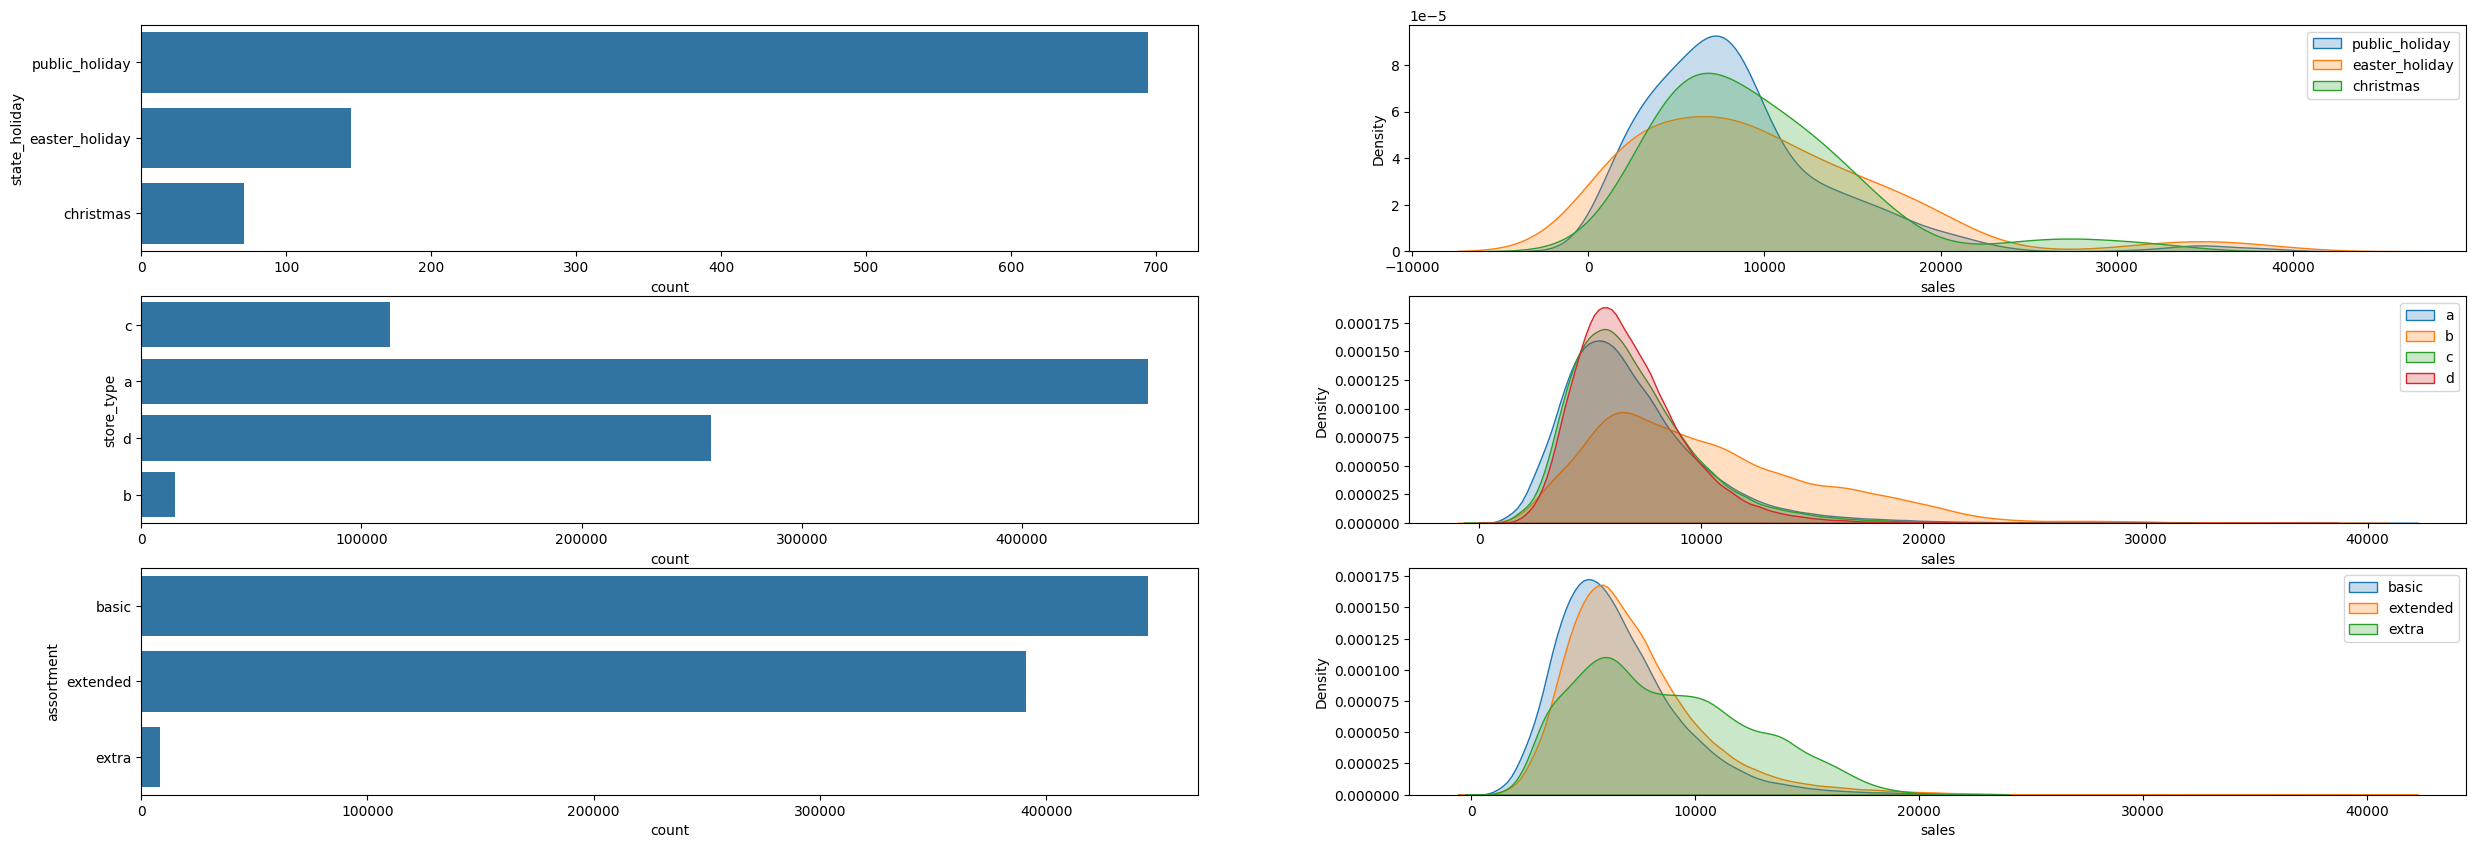

In [59]:
plt.figure(figsize=(30, 10))

plt.subplot(3, 2, 1)
a = df5[df5['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df5[df5['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()

plt.subplot(3, 2, 3)
sns.countplot(df5['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df5[df5['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df5[df5['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df5[df5['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df5[df5['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()

plt.subplot(3, 2, 5)
sns.countplot(df5['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df5[df5['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df5[df5['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df5[df5['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend()

## 5.2. Bivariate Analysis

### 5.2.1. Hypothese 1 🆗

Stores with a larger assortment should sell more?

**FALSE!** Stores with a LARGER ASSORTMENT sell **LESS**.

<Axes: xlabel='year_week'>

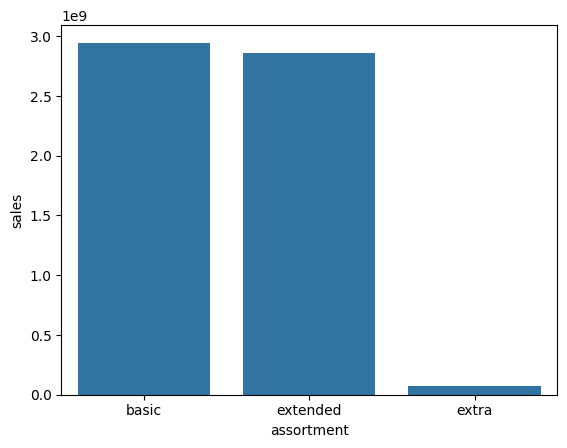

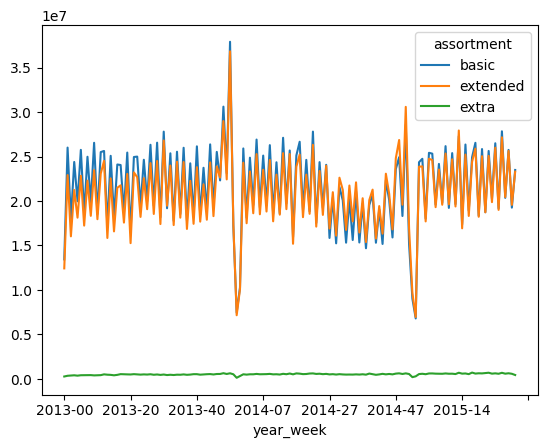

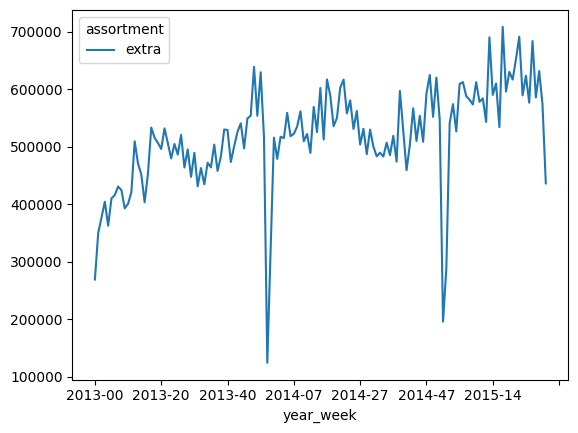

In [60]:
aux1 = df5[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df5[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### 5.2.2. Hypothese 2 🆗

Stores with closer competitors should sell less?

**FALSE!** Stores with a CLOSE COMPETITORS sell **MORE**.

C:\Users\Lucas\AppData\Local\Temp\ipykernel_17232\2037633991.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()


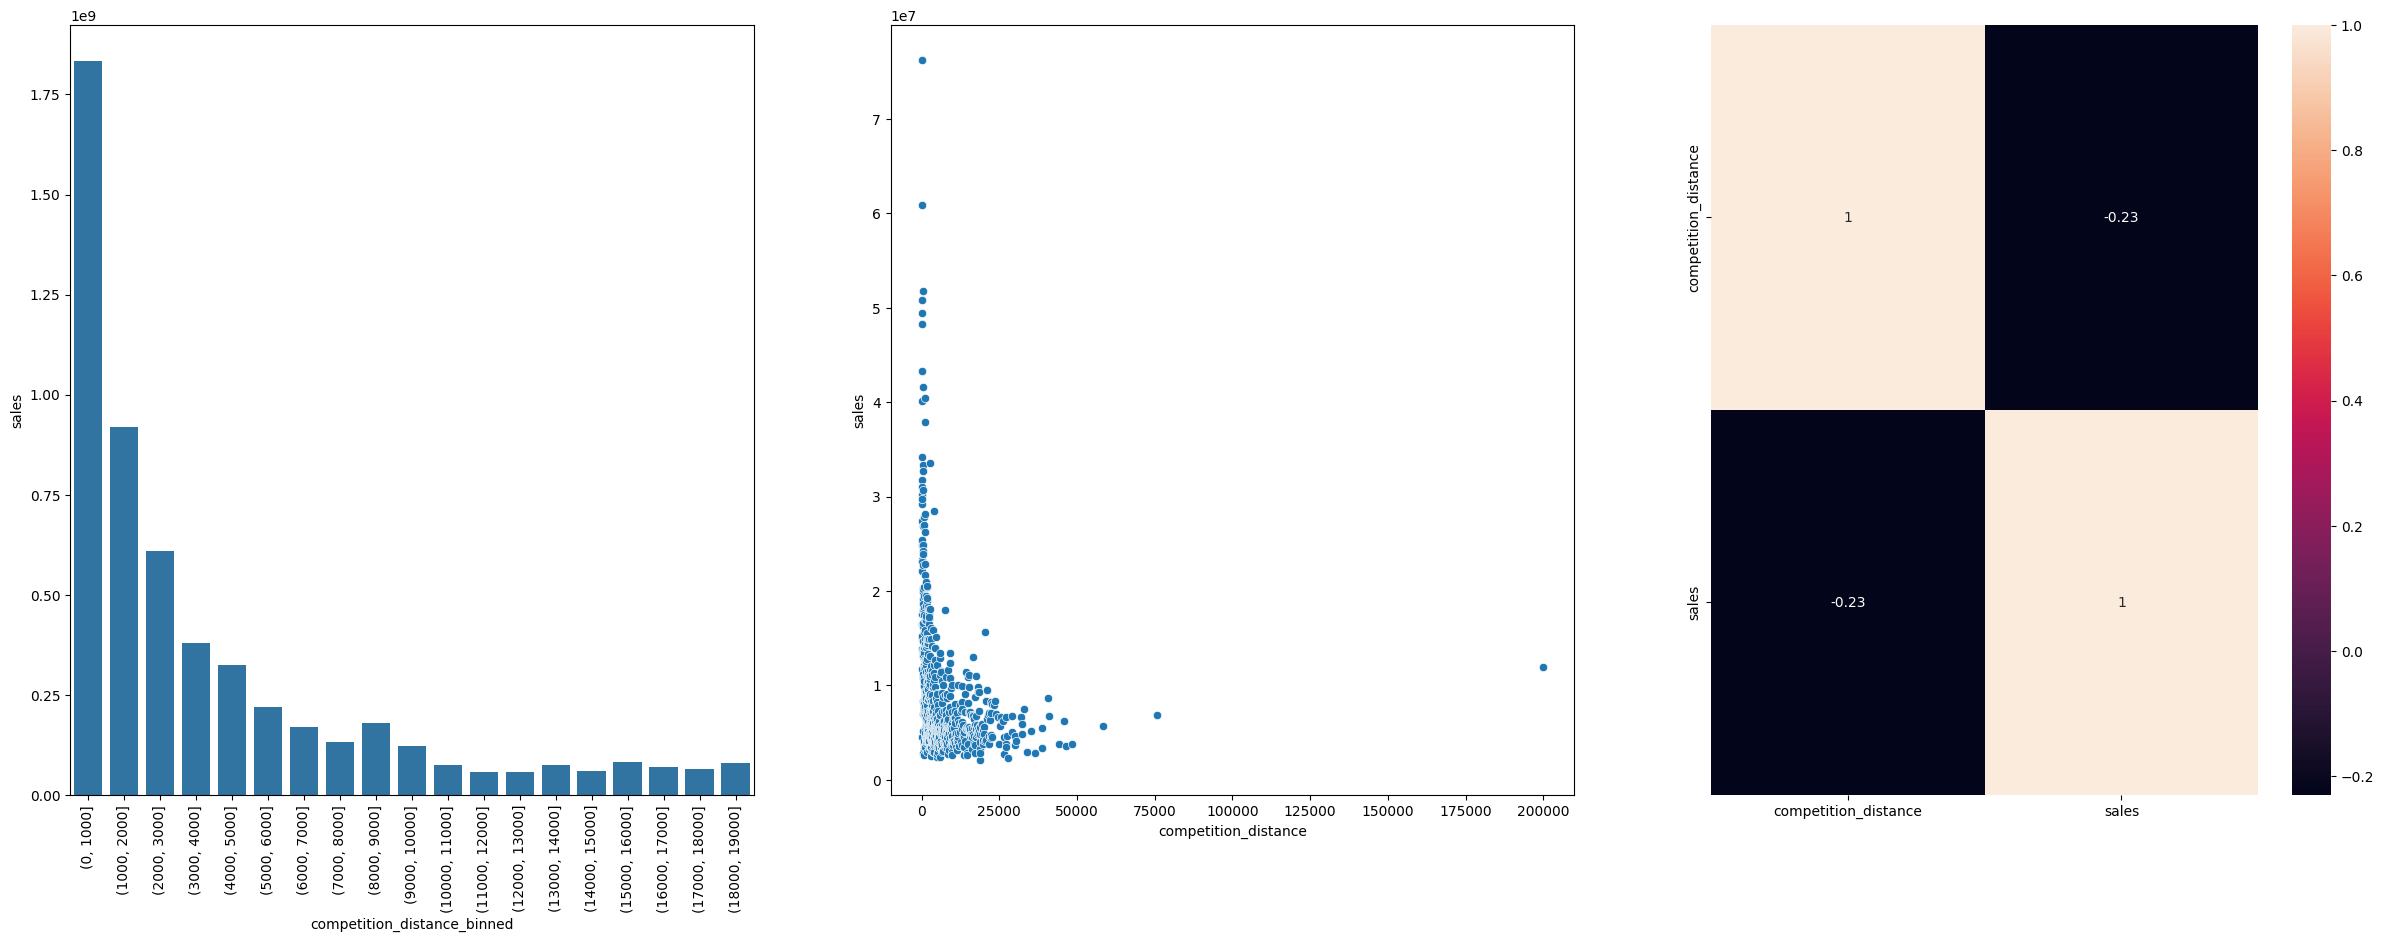

In [61]:
plt.figure(figsize=(30,10))

aux1 = df5[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
bins =  list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1[['competition_distance', 'sales']].corr(method='pearson'), annot=True);

### 5.2.3. Hypothese 3 🆗

Stores with competitors for a longer time should sell more.

**FALSE!** Store with COMPETITORS FOR A LONGER TIME sell **LESS.**

<Axes: >

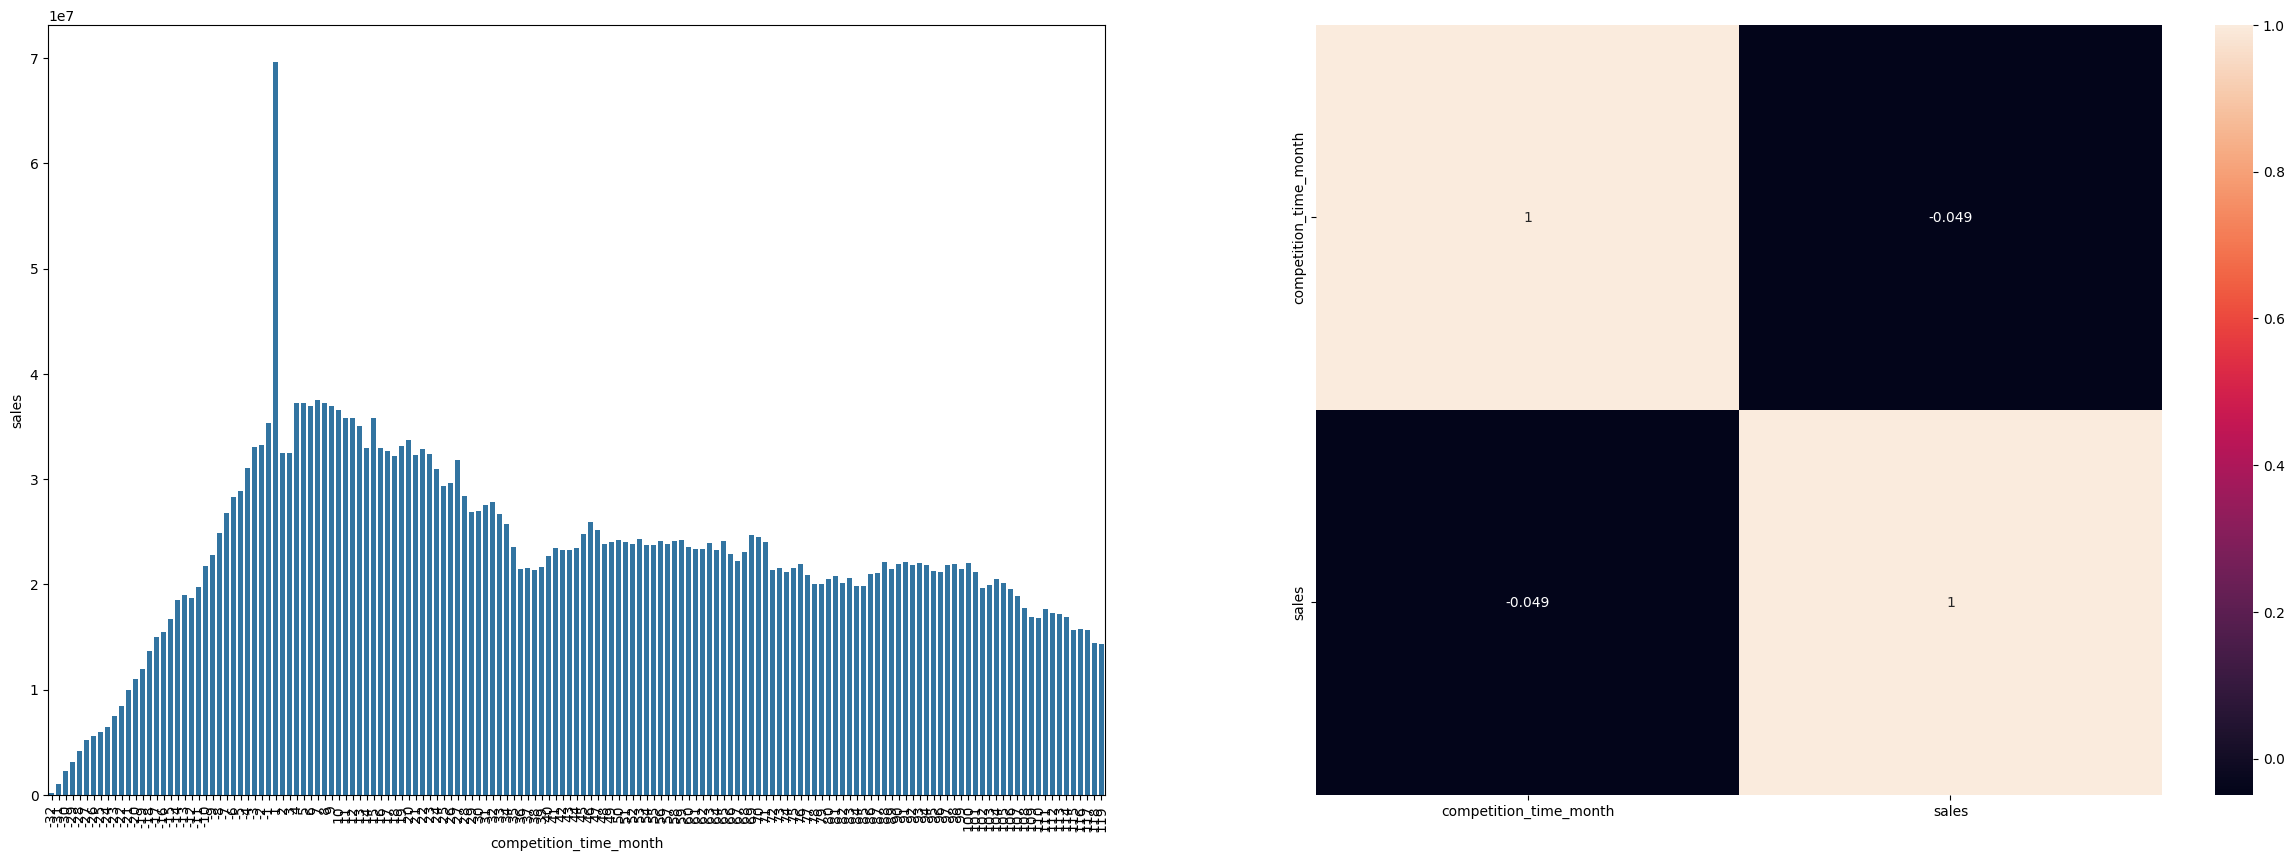

In [62]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
aux1= df5[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,2,2)
sns.heatmap(aux2.corr(method='pearson'), annot=True)

### 5.2.4. Hypothese 4 🆗

Stores with active promotions for a longer period should sell more.

**FALSE!** Store with ACTIVE PROMOTIONS FOR A LONGER PERIOD sell **LESS** after a certain promotion period.

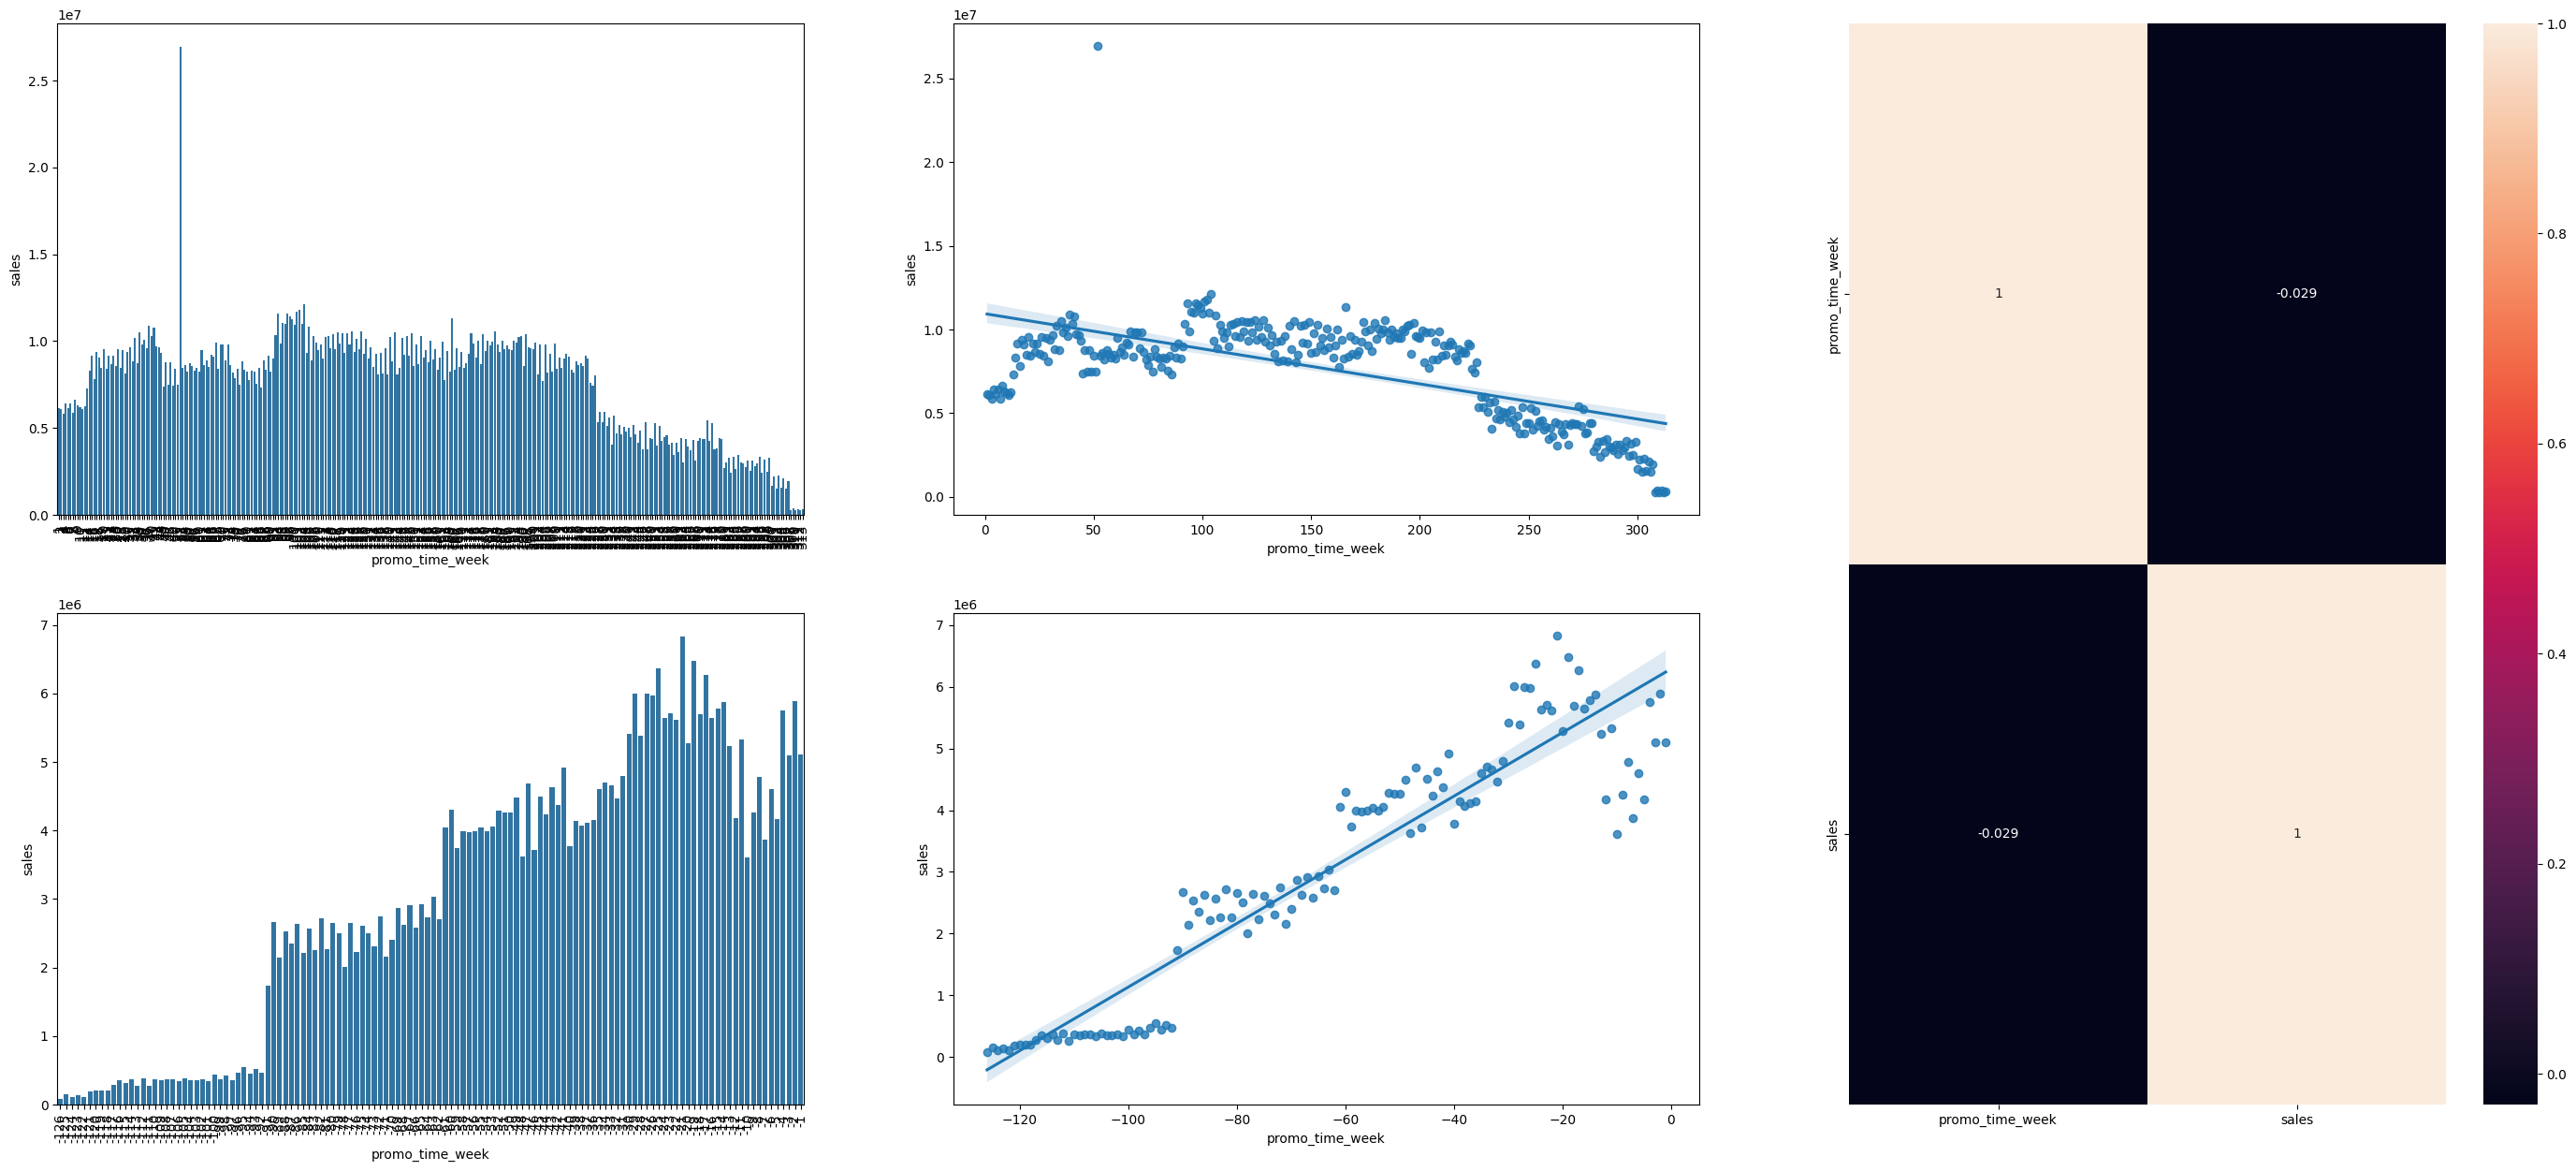

In [63]:
plt.figure(figsize=(35,15))
aux1 = df5[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # extend_promo
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # regular_promo
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 5.2.5. Hypothese 5 🔜

Stores with more days of promotion should sell more.

### 5.2.6. Hypothese 6 🆗

Stores with more consecutive promotions should sell more.

**FALSE!** Stores with MORE CONSECUTIVE PROMOTIONS sell **LESS.**

In [64]:
df5[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


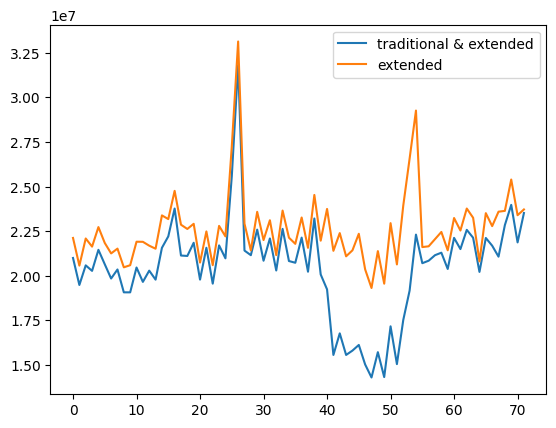

In [65]:
aux1 = df5[(df5['promo'] == 1) & (df5['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax)

ax.legend(labels=['traditional & extended', 'extended'])

### 5.2.7. Hypothese 7 🆗

Stores open during the Christmas holiday should sell more

**FALSE!** Stores open during the CHRISTMAS HOLIDAY sell **LESS.**

<Axes: xlabel='year', ylabel='sales'>

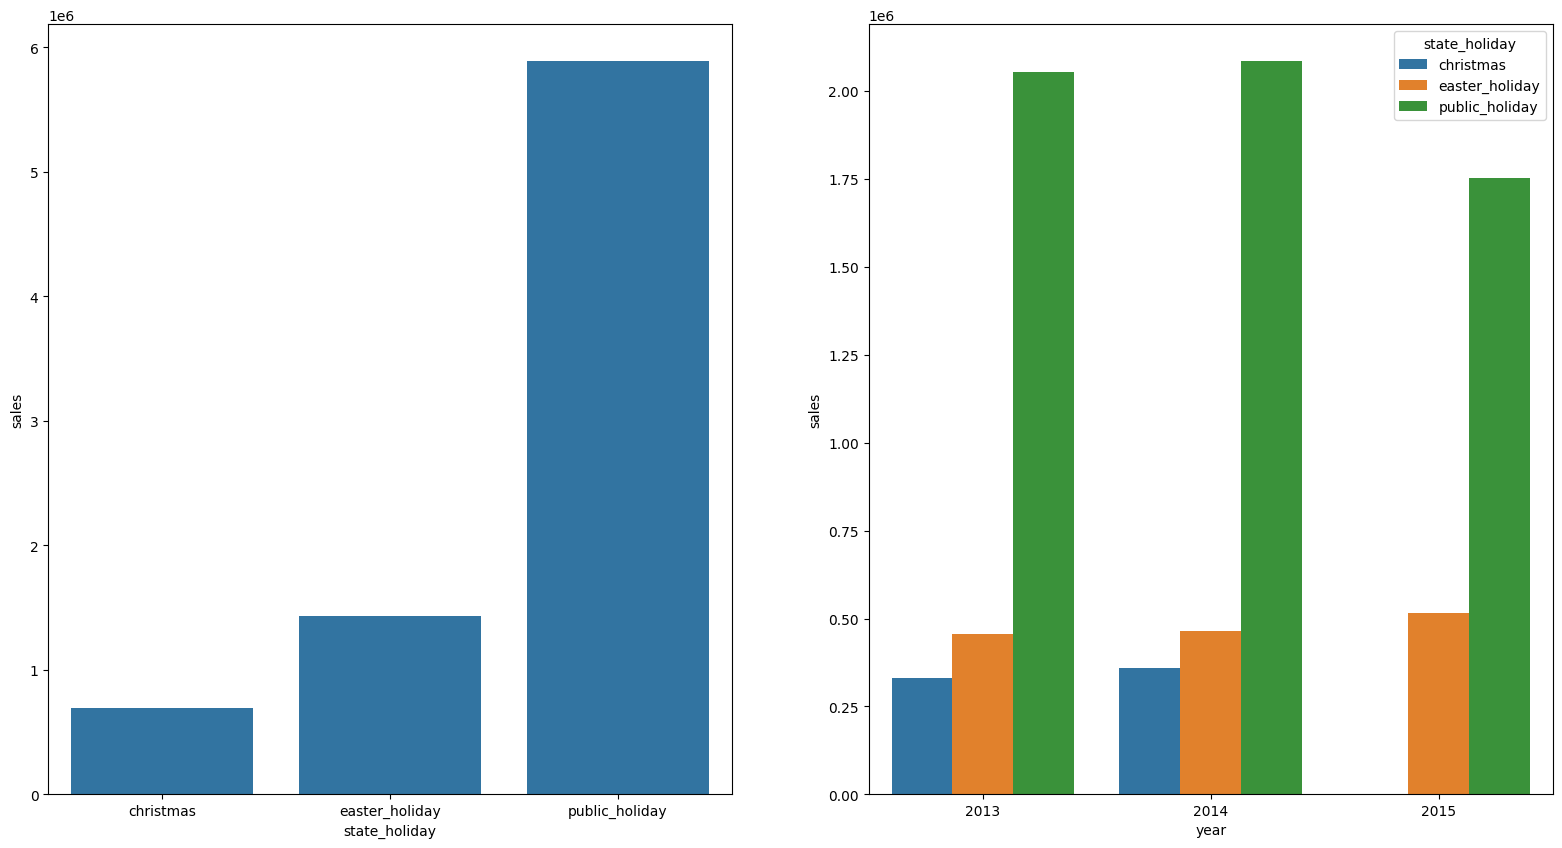

In [66]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)

aux = df5[df5['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday',  data=aux2)

### 5.2.8. Hypothese 8 🆗

Stores should sell more over the years.

**FALSE!** Stores sell **LESS** over the years.

<Axes: >

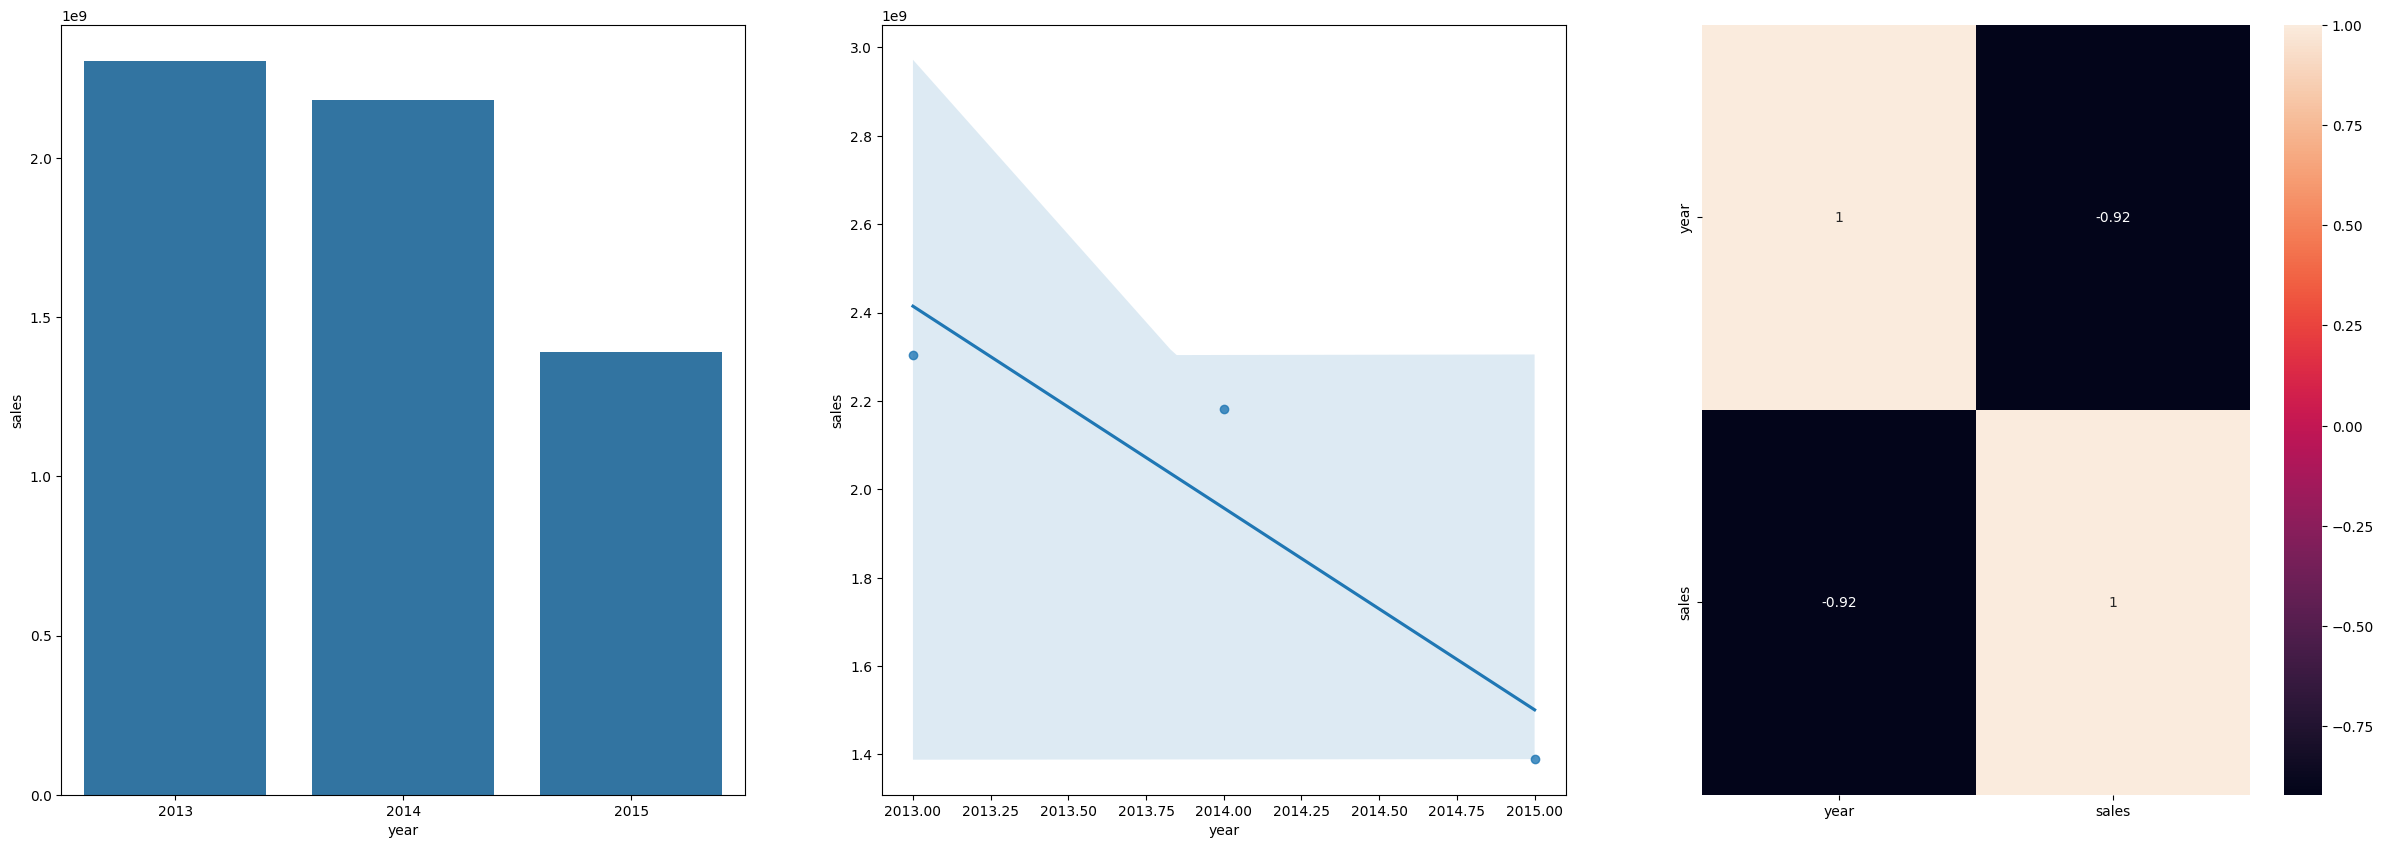

In [67]:
plt.figure(figsize=(30,10))

plt.subplot(1, 3, 1)
aux1 = df5[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 5.2.9. Hypothese 9 🆗

Stores should sell more in the second half of the year.

**FALSE!** Sores sell **LESS** in the second half of the year.

<Axes: >

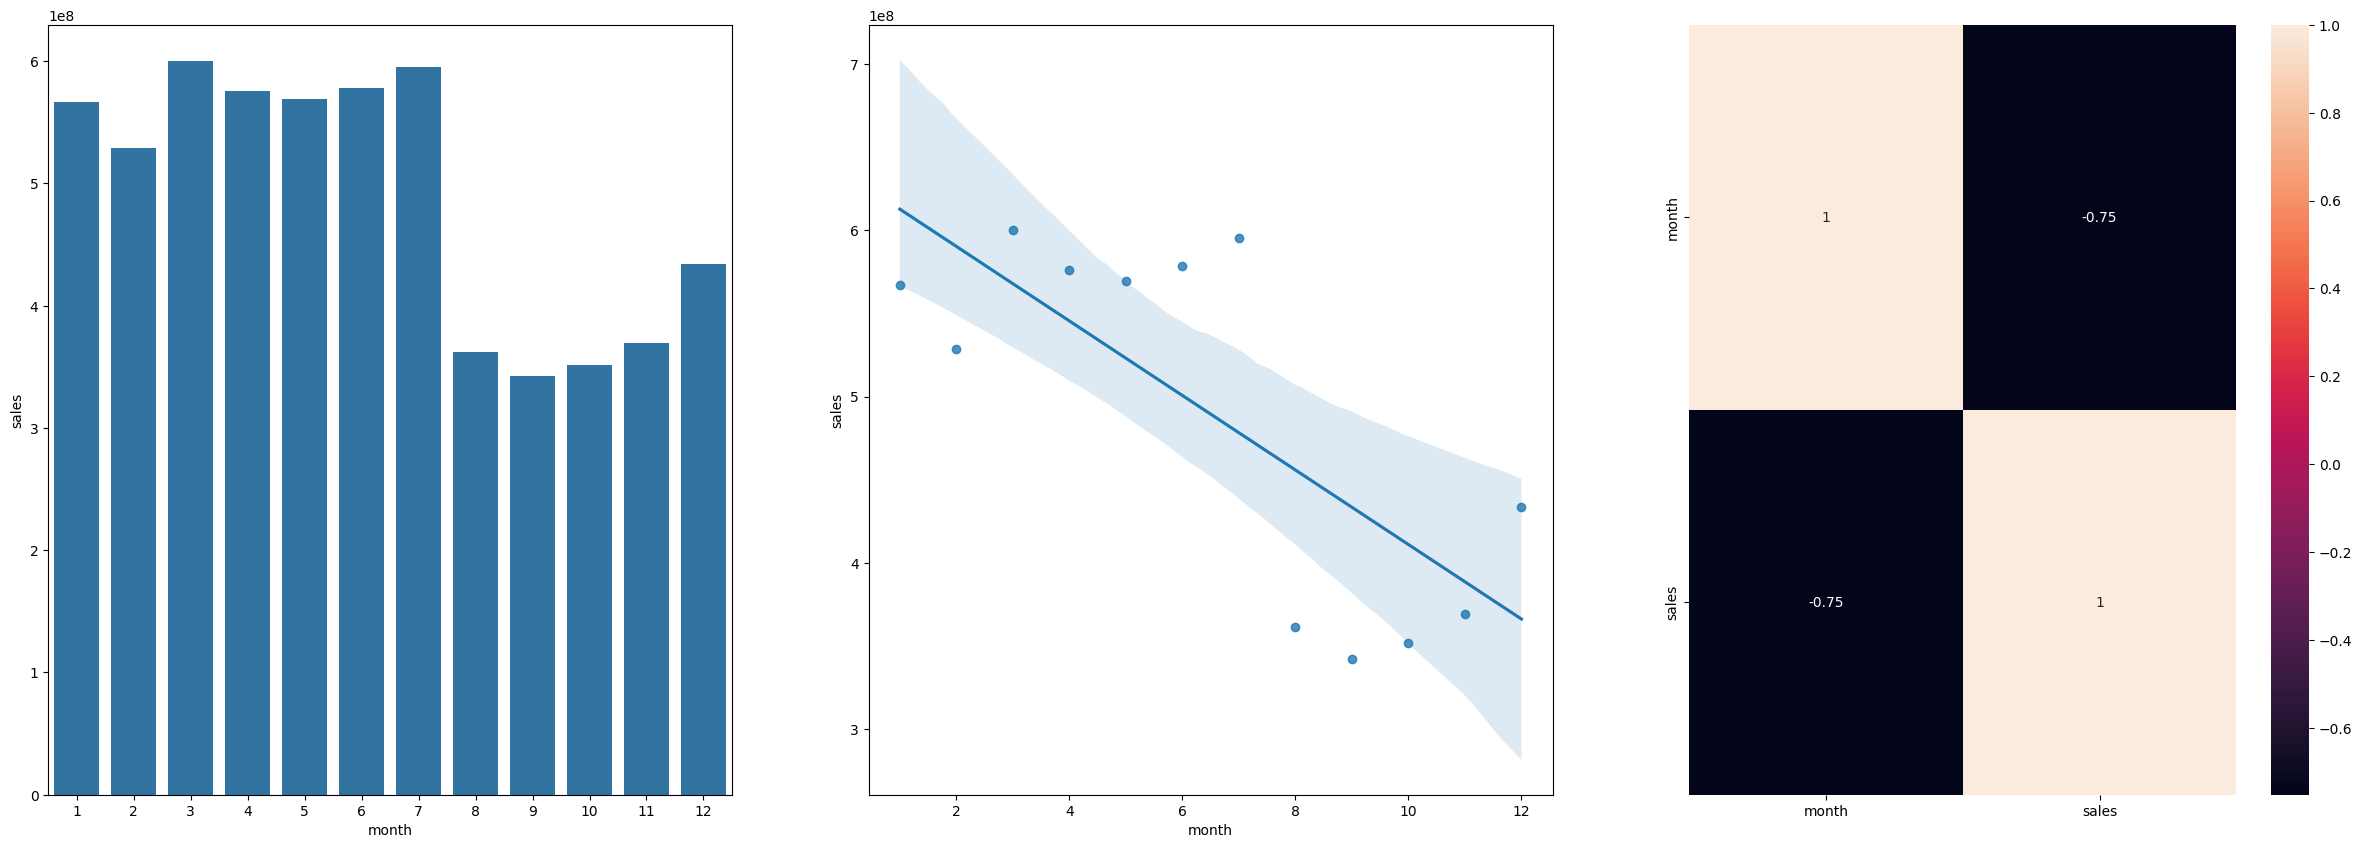

In [68]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
aux1 = df5[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 5.2.10. Hypothese 10 🆗

Stores should sell more after the 10th day of each month.

**TRUE!** Stores sell **MORE** after the 10th day of each month.

<Axes: xlabel='before_after', ylabel='sales'>

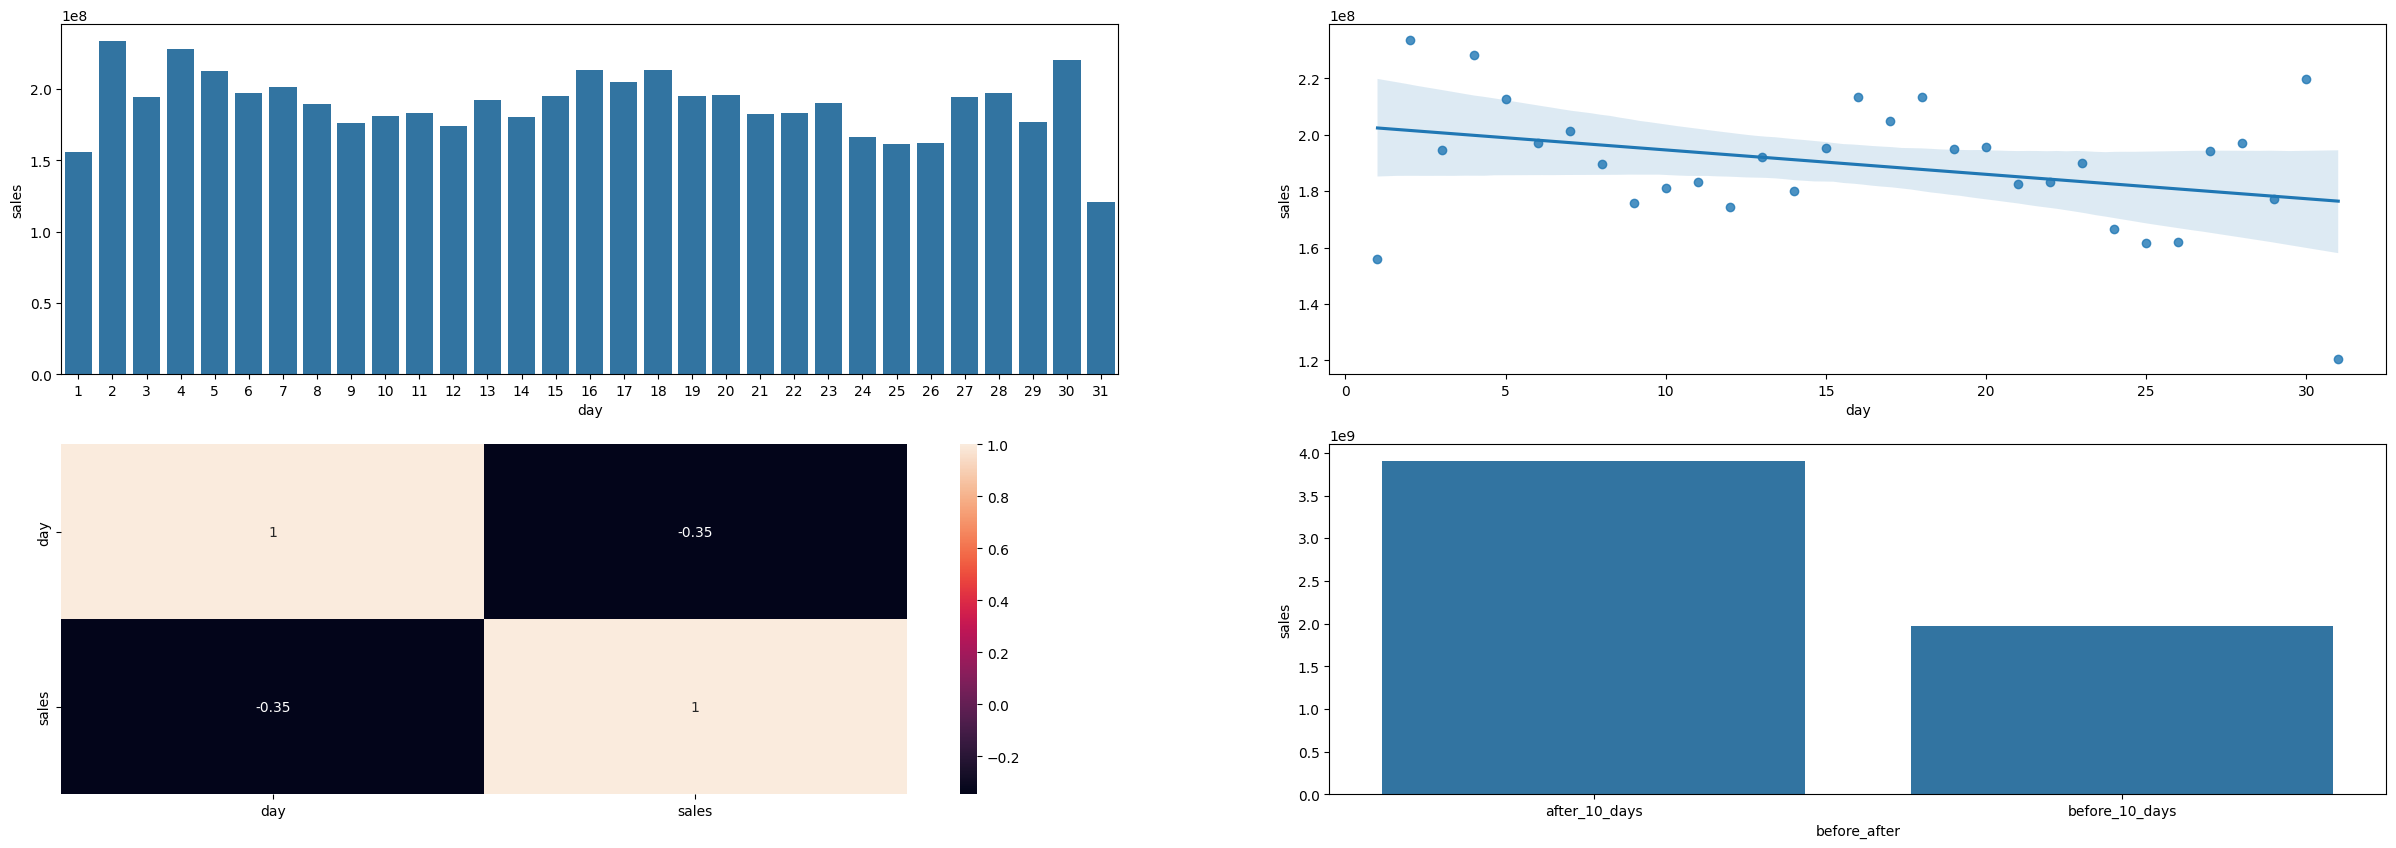

In [69]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 2, 1)
aux1 = df5[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)

### 5.2.11. Hypothese 11 🆗

Stores should sell less on weekends.

**TRUE!** Stores sell **LESS** on weekends.

<Axes: >

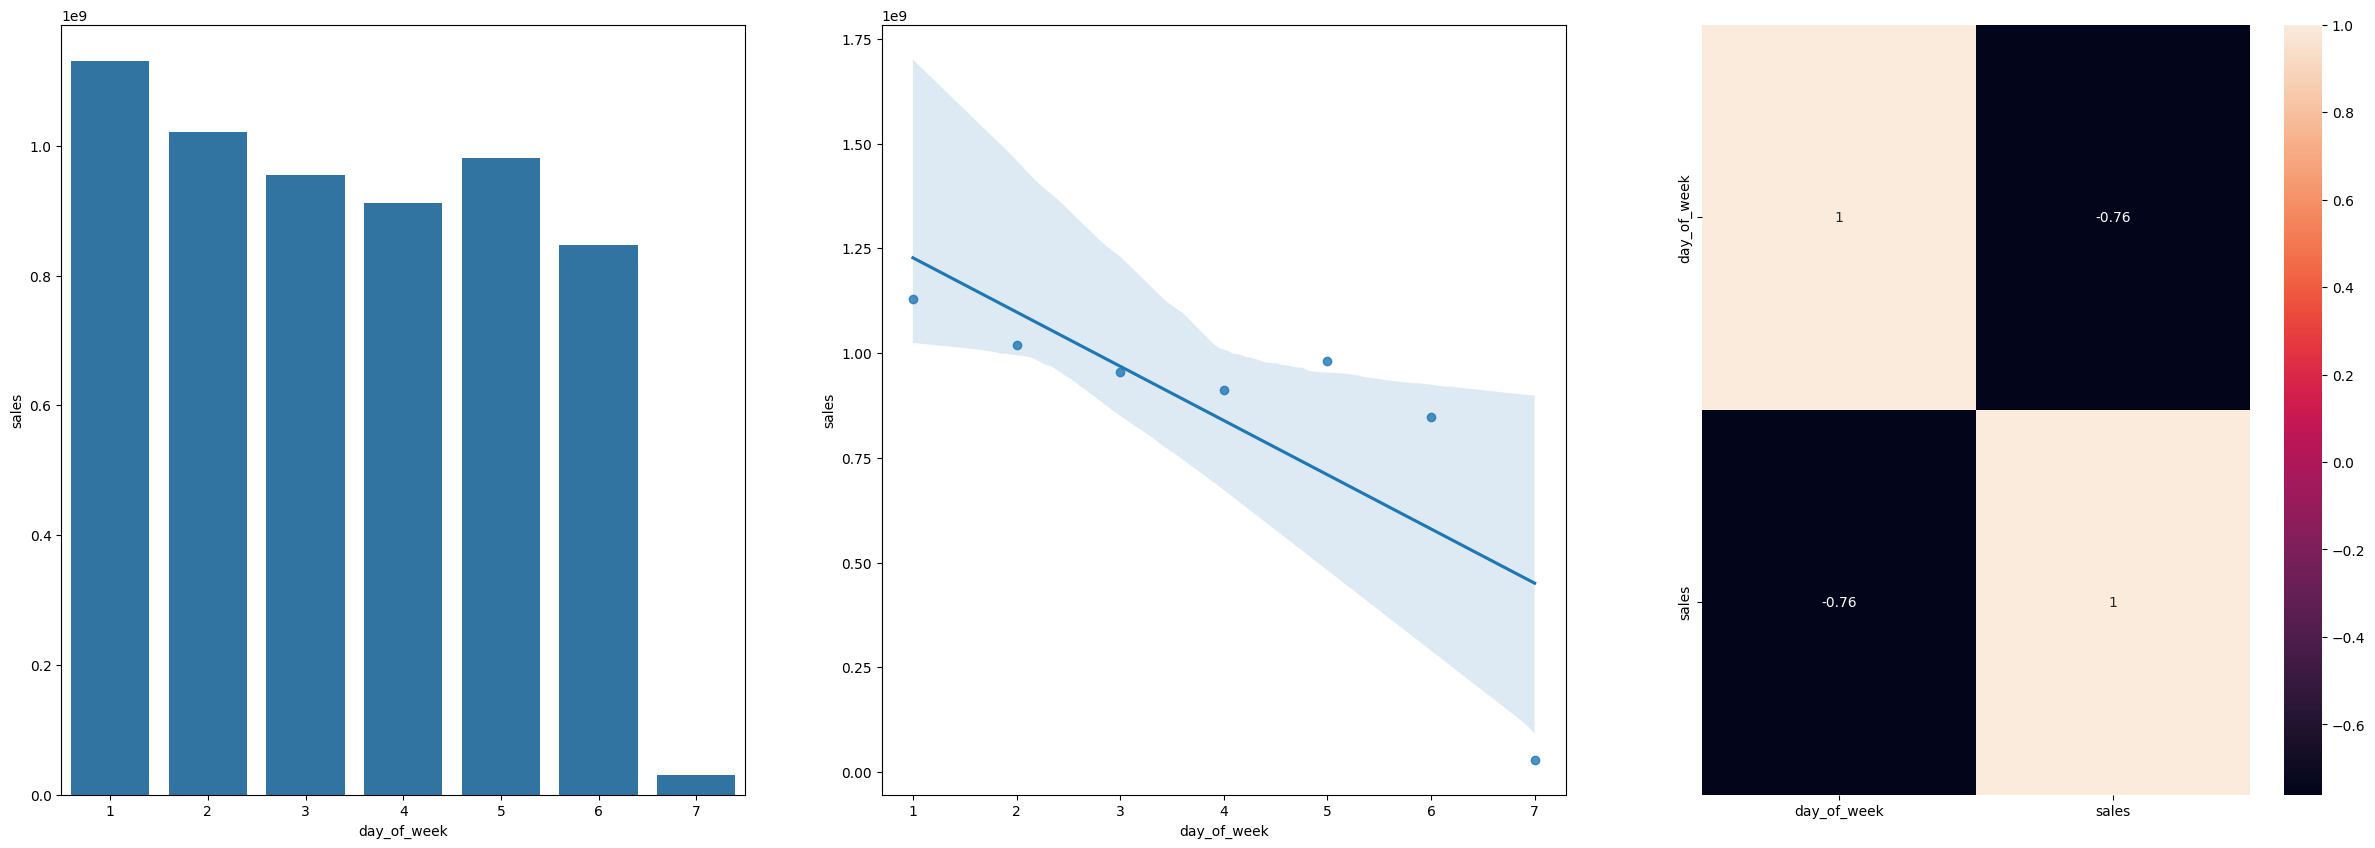

In [70]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
aux1 = df5[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 5.2.12. Hypothese 12 🆗

Stores should sell less during school periods

**TRUE!** Stores sell **LESS** during school holidays, except in the months of July and August

<Axes: xlabel='month', ylabel='sales'>

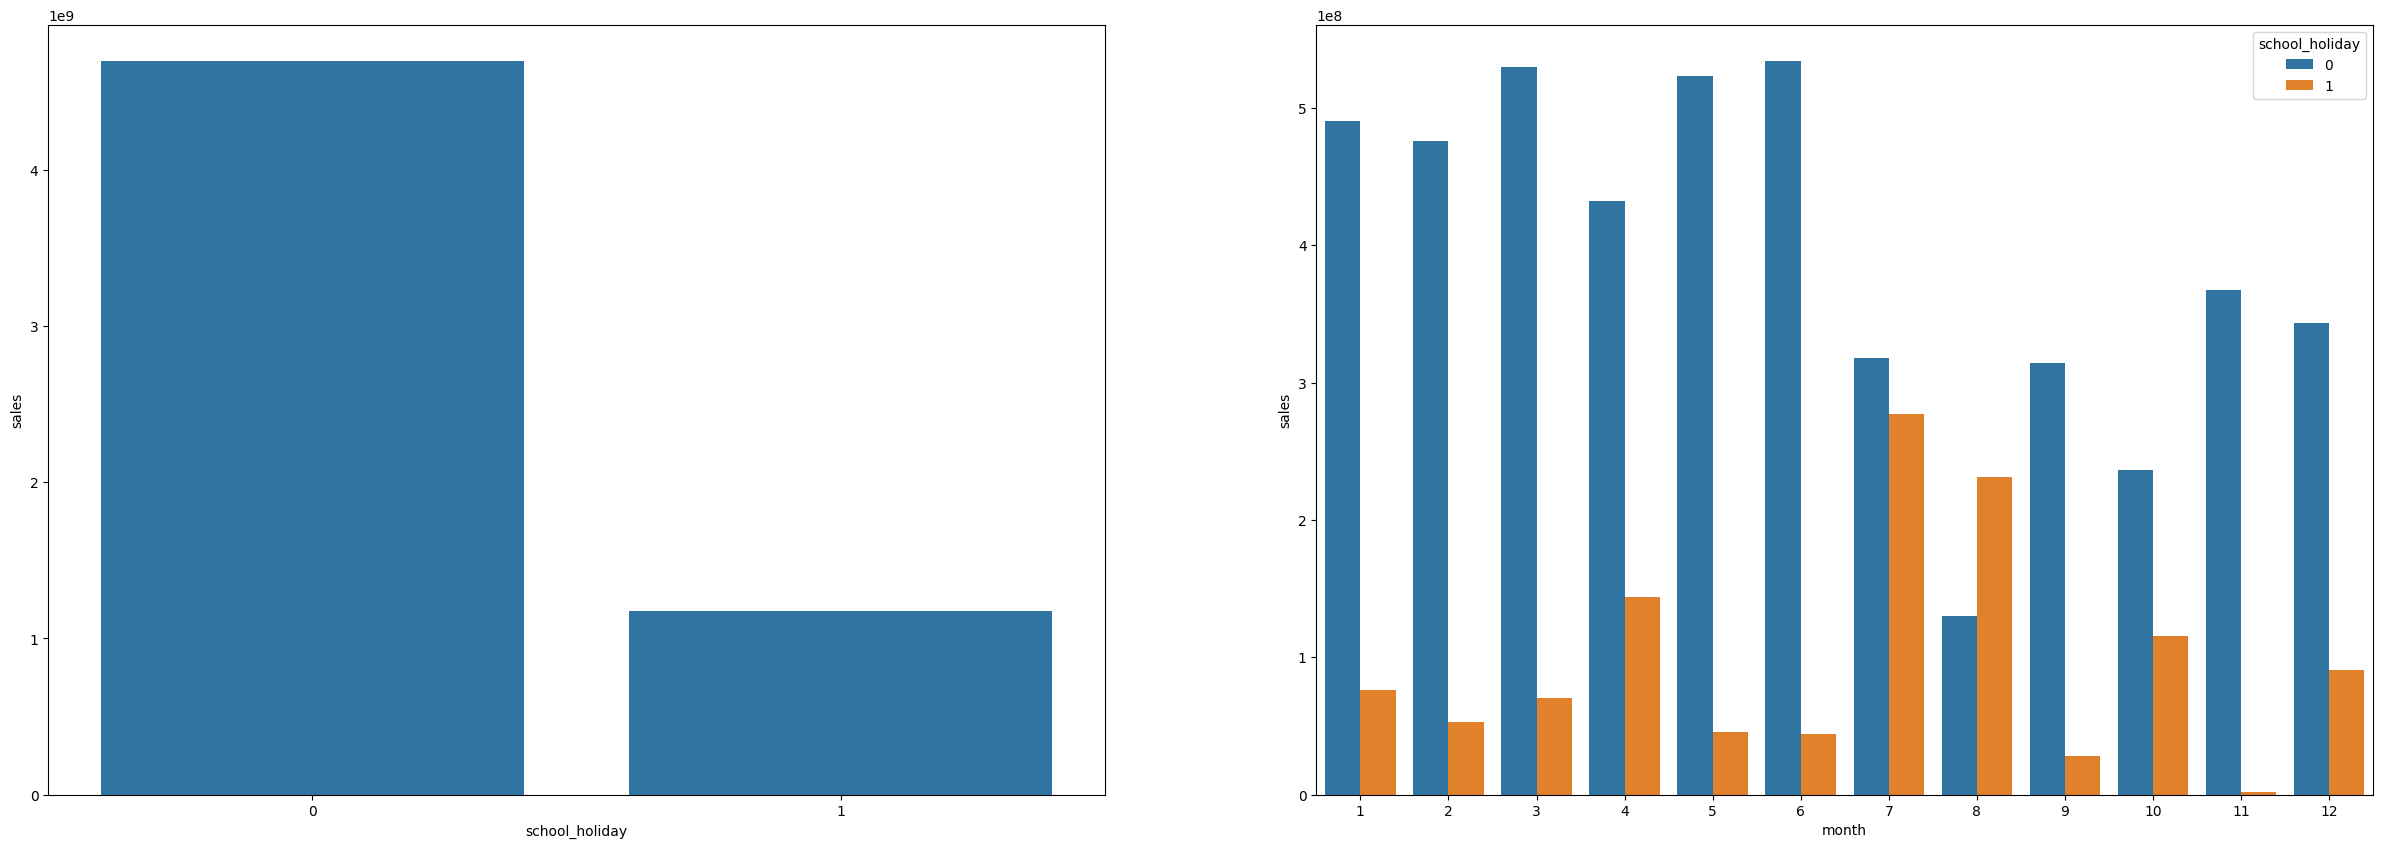

In [71]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)
aux1 = df5[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(1,2, 2)
aux2 = df5[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

## 5.3 Resume Hypotheses

In [72]:
tab =[['Hypotheses', 'Conclusion', 'Relevance'],
      ['H01', 'False', 'Low'],
      ['H02', 'False', 'Medium'],
      ['H03', 'False', 'Medium'],
      ['H04', 'False', 'Low'],
      ['H05', '-', '-'],
      ['H07', 'False', 'Low'],
      ['H08', 'False', 'Medium'],
      ['H09', 'False', 'High'],
      ['H10', 'False', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'High'],
      ['H13', 'True', 'Low']]

print(tabulate(tab, headers='firstrow' ))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H01           False         Low
H02           False         Medium
H03           False         Medium
H04           False         Low
H05           -             -
H07           False         Low
H08           False         Medium
H09           False         High
H10           False         High
H11           True          High
H12           True          High
H13           True          Low


## 5.4. Multivariate Analysis

### 5.4.1. Numerical Attributes

In [73]:
num_attributes = get_numerical_attributes(df5)

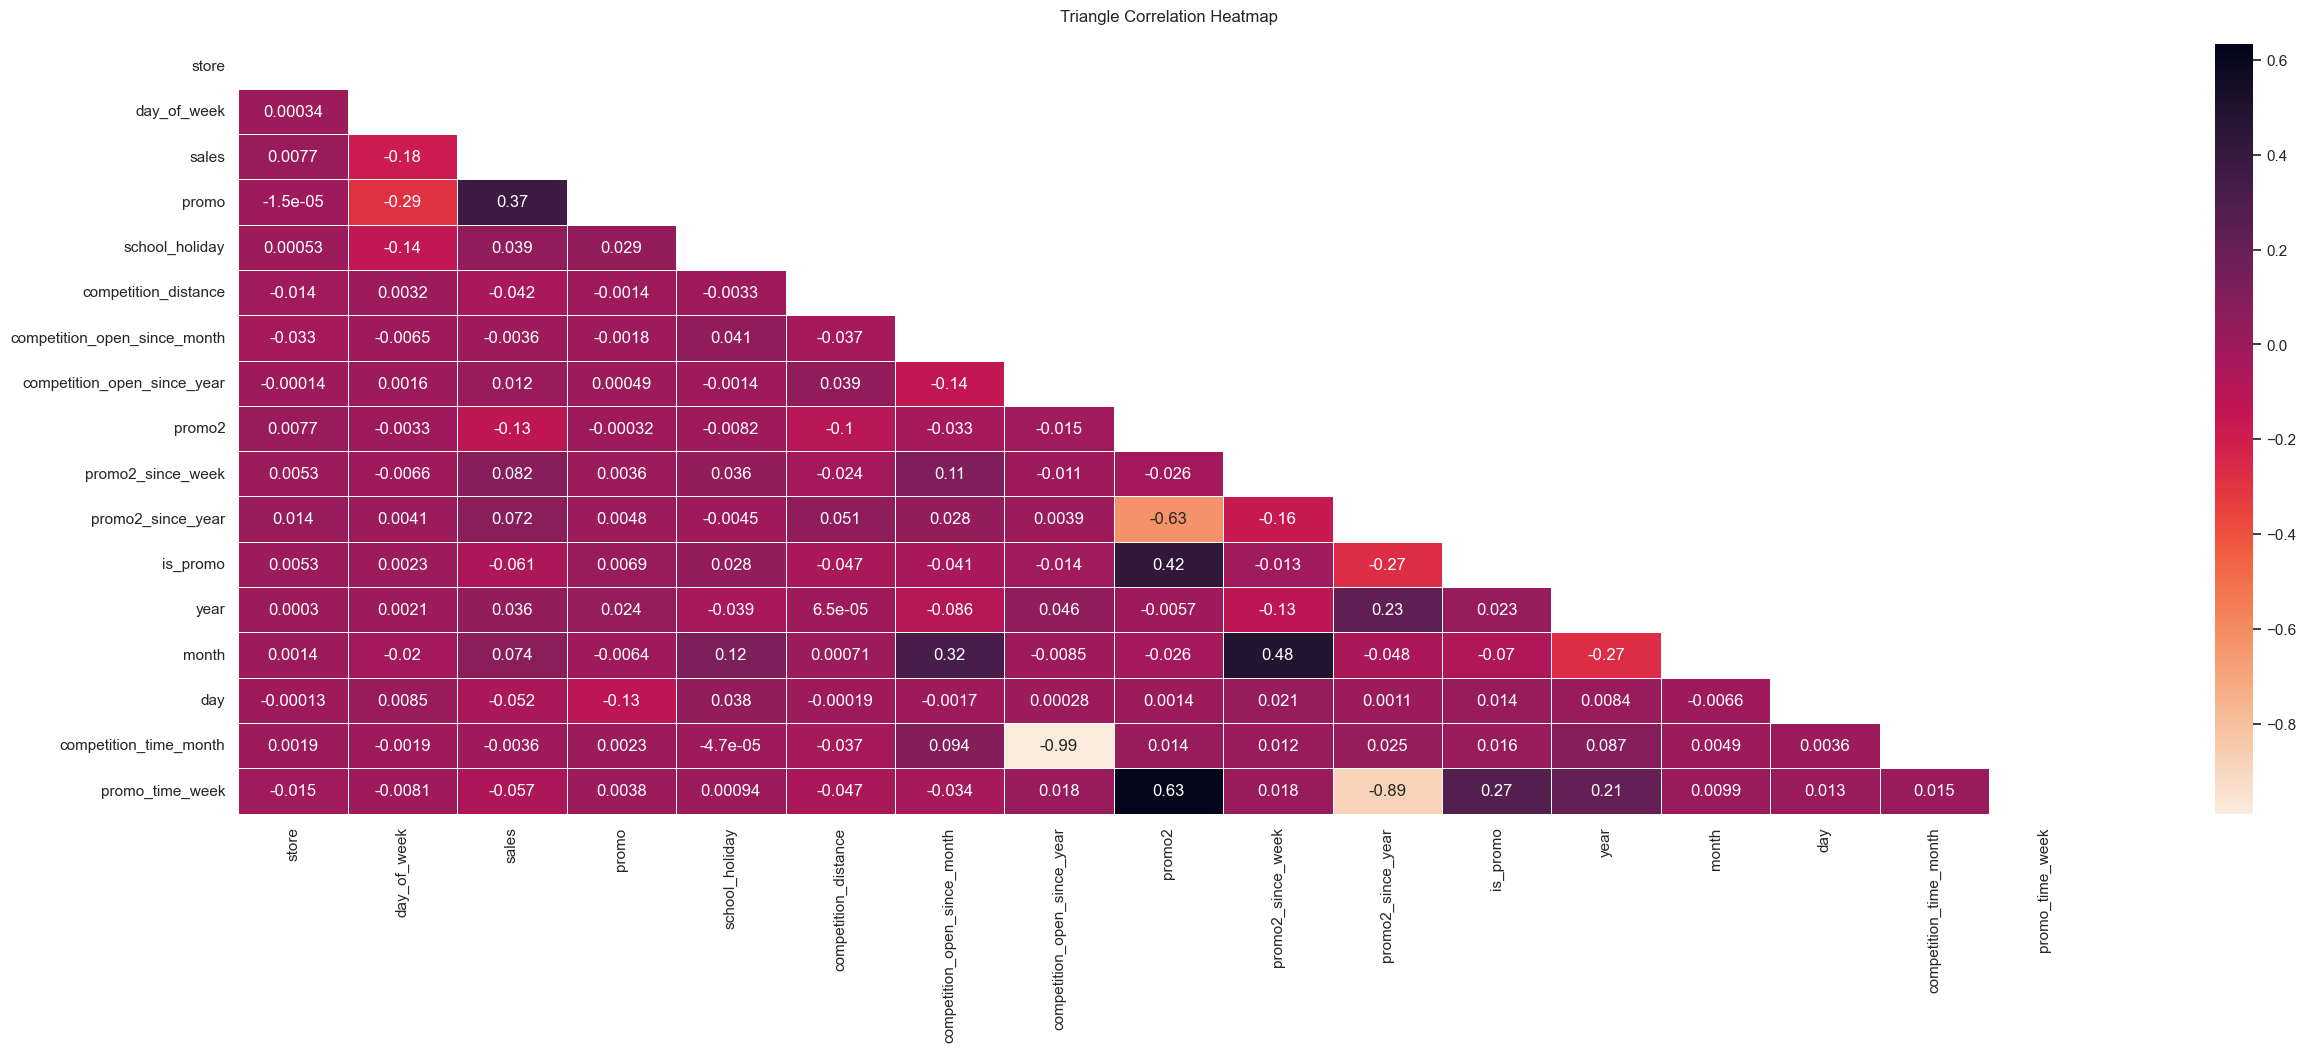

In [74]:
plot_triangle_correlation_heatmap(num_attributes.corr(method='pearson'))

### 5.4.2. Categorical Attributes

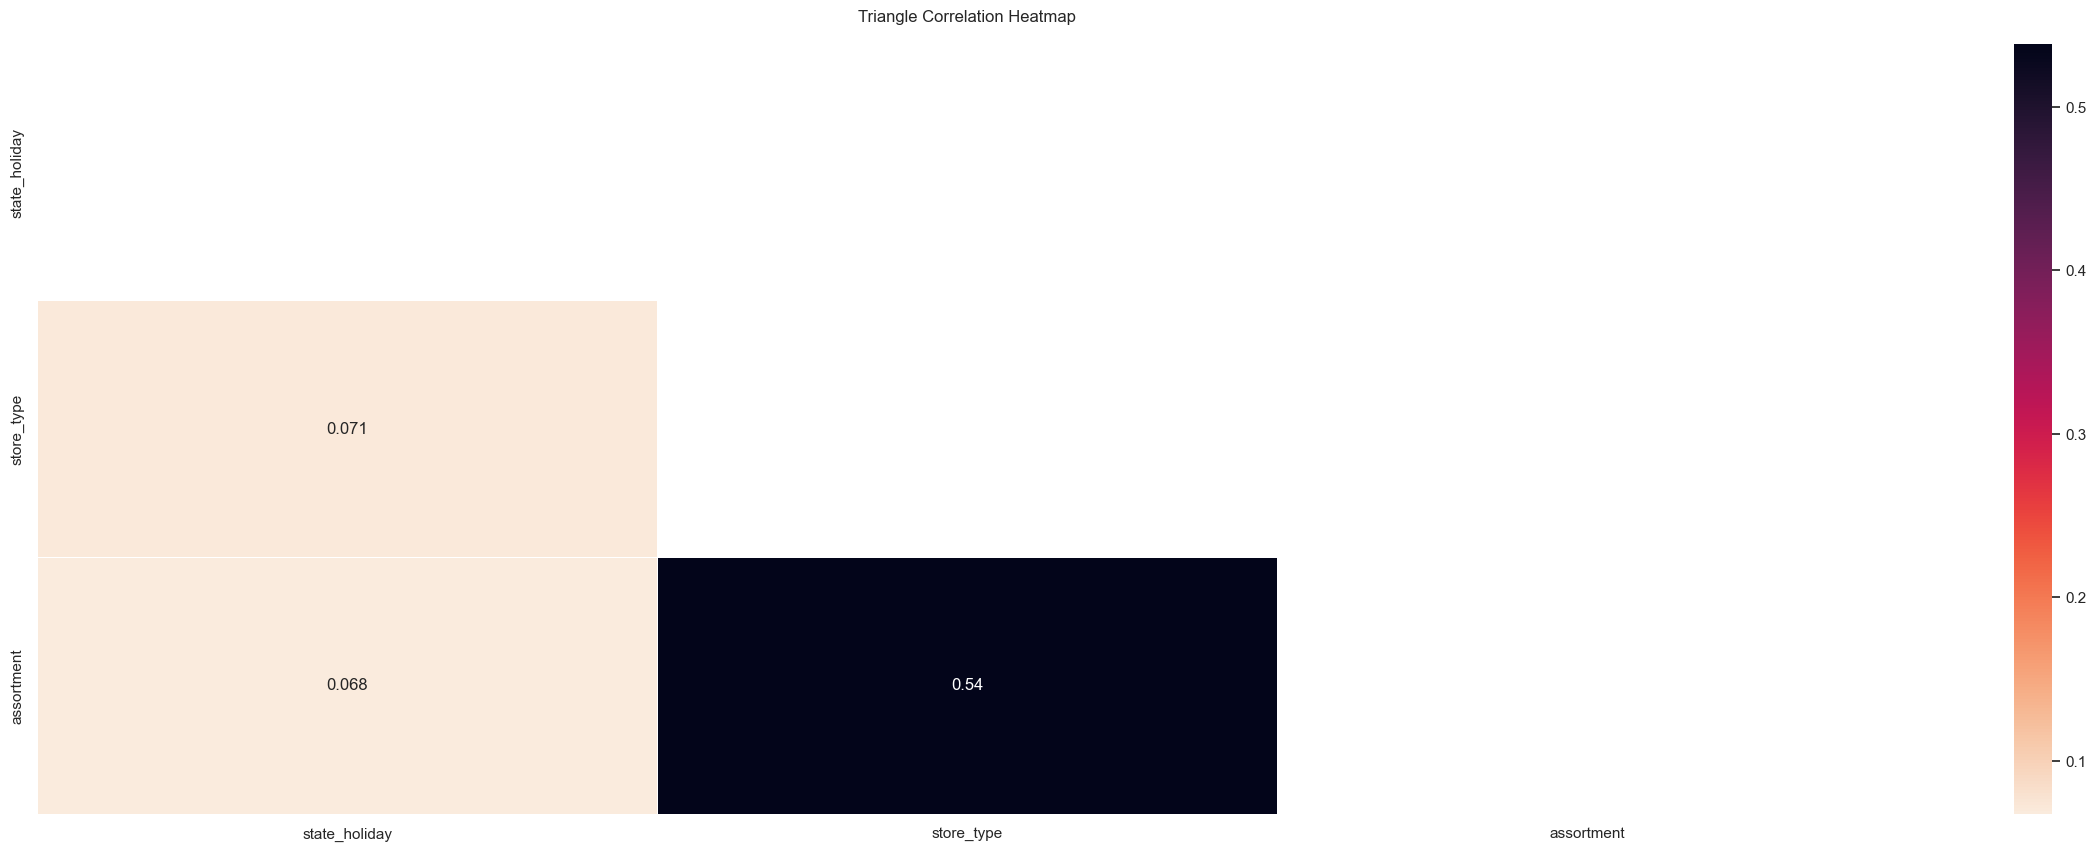

In [75]:
cat_attributes = get_categorical_attributes(df5)

a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type'])
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type'])
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])

cat_df = pd.DataFrame({'state_holiday': [a1, a2, a3],
                       'store_type': [a4, a5, a6],
                       'assortment': [a7, a8, a9]})

cat_df = cat_df.set_index(cat_df.columns)

plot_triangle_correlation_heatmap(cat_df)

# 6.0. DATA PREPARATION

In [76]:
df6 = df5.copy()

In [77]:
df6.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
642076,622,2,2013-12-03,6566,1,regular_day,0,a,extended,200000.0,...,0,2013,12,3,49,2013-48,2013-12-01,0,2013-12-02,0
307942,599,4,2014-10-16,7320,0,regular_day,0,d,extended,580.0,...,0,2014,10,16,42,2014-41,2014-11-01,-1,2014-10-13,0
905752,43,3,2013-04-10,7573,1,regular_day,0,d,basic,4880.0,...,1,2013,4,10,15,2013-14,2013-04-01,0,2009-09-07,187
692563,934,6,2013-10-19,4143,0,regular_day,0,a,extended,5460.0,...,1,2013,10,19,42,2013-41,2013-10-01,0,2011-03-28,133
24753,224,4,2015-07-09,6439,0,regular_day,0,d,extended,7930.0,...,1,2015,7,9,28,2015-27,2015-07-01,0,2012-12-31,131


In [78]:
get_descriptive_info(df6)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,day_of_week,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
2,sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
3,promo,0.0,1.0,1.0,0.446356,0.0,0.497114,0.215824,-1.953425
4,school_holiday,0.0,1.0,1.0,0.193578,0.0,0.395102,1.551109,0.405939
5,competition_distance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
6,competition_open_since_month,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
7,competition_open_since_year,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
8,promo2,0.0,1.0,1.0,0.498670,0.0,0.499998,0.005320,-1.999976
9,promo2_since_week,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815


## 6.1. Normalization


During the univariate analysis, none of the characteristics showed a Gaussian distribution, so I didn't find it necessary to normalize any of them.

## 6.2. Rescaling

In [79]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df6['competition_distance'] = rs.fit_transform(df6[['competition_distance']].values)

# competition time month
df6['competition_time_month'] = rs.fit_transform(df6[['competition_time_month']].values)

# year
df6['year'] = mms.fit_transform(df6[['year']].values)

# promo time week
df6['promo_time_week'] = mms.fit_transform(df6[['promo_time_week']].values)

## 6.3. Transformation

### 6.3.1. Encoding

In [80]:
# state_holiday - One Hot Encoding
df6 = pd.get_dummies(df6, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# store_type - Label Encoding
le = LabelEncoder()
df6['store_type'] = le.fit_transform(df6['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra': 2, 'extended': 3}
df6['assortment'] = df6['assortment'].map(assortment_dict)

### 6.3.2. Response Variable Transformation

In [81]:
df6['sales'] = np.log1p(df6['sales'])

### 6.3.3. Cyclical Nature Transformation

In [82]:
# day of week
df6['day_of_week_sin'] = df6['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df6['day_of_week_cos'] = df6['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))


# month
df6['month_sin'] = df6['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df6['month_cos'] = df6['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df6['day_sin'] = df6['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df6['day_cos'] = df6['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df6['week_of_year_sin'] = df6['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df6['week_of_year_cos'] = df6['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# 7.0. FEATURE SELECTION

In [83]:
df7 = df6.copy()

In [84]:
cols_to_convert = df7.select_dtypes(include=['int32']).columns
df7[cols_to_convert] = df7[cols_to_convert].astype('int64')

In [85]:
df7.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_since               datetime64[ns]
competition_t

In [86]:
df7.sample(5).T

,276527,324137,593895,798481,967171
store,1047,961,386,927,137
day_of_week,3,1,3,2,4
date,2014-11-19 00:00:00,2014-09-29 00:00:00,2014-01-15 00:00:00,2013-07-16 00:00:00,2013-02-14 00:00:00
sales,8.251925,8.939843,8.833463,9.024252,8.844048
promo,0,1,0,1,0
school_holiday,0,0,0,0,1
store_type,0,3,3,0,0
assortment,1,3,3,1,1
competition_distance,0.229032,1.145161,-0.140323,-0.298387,-0.096774
competition_open_since_month,11,9,4,7,7


## 7.1. Split DataFrame into training and test dataset

In [87]:
# removing features that were created to help create other features

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df7 = df7.drop(columns=cols_drop, axis=1)

In [88]:
# Find the day that starts the last 6 weeks of data

df7[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [89]:
# training dataset
X_train = df7[df7['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df7[df7['date'] >= '2015-06-19']
y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')

print(f'\nTesting Min Date: {X_test["date"].min()}')
print(f'Testing Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


## 7.2. Boruta as Feature Selector

In [90]:
# # Training and test dataset for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs =-1)

# # Define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=37).fit(X_train_n, y_train_n)

### 7.2.1. Best Features from Boruta

In [91]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [92]:
# cols_selected_boruta

In [93]:
# cols_not_selected_boruta

## 7.3 Manual Feature Selection

In [94]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 8.0. MACHINE LEARNING MODELLING

In [95]:
df8 = df7.copy()

In [96]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 8.1. Average Model

In [97]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2  = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 8.2. Linear Regression Model

In [98]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 8.2.1. Linear Regression Model - Cross Validation

In [99]:
lr_result_cv = cross_validation(x_training, 'Linear Regression', lr, 5)

In [100]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37


## 8.3. Linear Regression Regularized Model - Lasso

In [101]:
# model
lrr = Lasso(alpha=0.01, max_iter=10000).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 8.3.1. Lasso - Cross Validation

In [102]:
lrr_result_cv = cross_validation(x_training, 'Lasso', lrr, 5)

In [103]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


## 8.4. Random Forest Regressor

In [104]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=37).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.647545,0.100798,1018.553446


### 8.4.1. Random Forest Regressor - Cross Validation

In [105]:
rf_result_cv = cross_validation(x_training, 'Random Forest Regressor', rf, 5)

In [106]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.85+/-221.57,0.12+/-0.02,1259.62+/-324.48


## 8.5. XGBoost Regressor

In [107]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)


# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1685.0258,0.250304,2463.213643


### 8.5.1. XGBoost Regressor - Cross Validation

In [108]:
xgb_result_cv = cross_validation(x_training, 'XGBoost Regressor', model_xgb, 5)

In [109]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1859.87+/-289.14,0.25+/-0.01,2688.49+/-432.73


## 8.6. Compare Model's Performance

### 8.6.1. Single Performance

In [110]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,684.647545,0.100798,1018.553446
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1685.025800,0.250304,2463.213643
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 8.6.2. Real Performance - Cross Validation

In [111]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.85+/-221.57,0.12+/-0.02,1259.62+/-324.48
0,XGBoost Regressor,1859.87+/-289.14,0.25+/-0.01,2688.49+/-432.73
0,Linear Regression,2081.73+/-295.63,0.3+/-0.02,2952.52+/-468.37
0,Lasso,2116.38+/-341.5,0.29+/-0.01,3057.75+/-504.26


# 9.0. HYPERPARAMETER FINE TUNING

In [112]:
df9 = df8.copy()

In [113]:
df9.head().T

,0,1,2,3,4
store,1,2,3,4,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,8.568646,8.71029,9.025816,9.546527,8.481151
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387
competition_open_since_month,9,11,12,9,4
competition_open_since_year,2008,2007,2006,2009,2015


## 9.1. Random Search

In [114]:
# param ={'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9 ],
#         'min_child_weight': [3, 8, 15]}

# MAX_EVAL = 10

In [115]:
# final_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)

#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])

#     # performance    
#     xgb_result = cross_validation( x_training, 'XGBoost Regressor', model_xgb, 2, False)
#     final_result = pd.concat([final_result, xgb_result])

# final_result

## 9.2. Random Final

In [127]:
param_tuned ={'n_estimators': 1700,
              'eta': 0.03,
              'max_depth': 9,
              'subsample': 0.5,
              'colsample_bytree': 0.7,
              'min_child_weight': 3}

In [128]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)


# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance    
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,631.609985,0.091209,931.453131


In [129]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.0062591275412650854

# 10.0.  ERROR TRANSLATION AND INTERPRETATION

In [130]:
df10 = X_test[cols_selected_boruta_full].copy()

In [131]:
# reescale
df10['sales'] = np.expm1(df10['sales'])
df10['predictions'] = np.expm1(yhat_xgb_tuned)

## 10.1. Business Performance

In [132]:
# sum of predictions
df10_sum_pred = df10[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df10_mae = df10[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df10_mape = df10[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df10_merge = pd.merge(df10_mae, df10_mape, how='inner', on='store')
df10_report = pd.merge(df10_sum_pred, df10_merge)

#Scenearios
df10_report['worst_scenario'] = df10_report['predictions'] - df10_report['MAE']
df10_report['best_scenario'] = df10_report['predictions'] + df10_report['MAE']

df10_report = df10_report[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [133]:
sales_report = df10_report.copy()

sales_report['predictions'] = sales_report['predictions'].round(2)
sales_report['worst_scenario'] = sales_report['worst_scenario'].round(2)
sales_report['best_scenario'] = sales_report['best_scenario'].round(2)
sales_report['MAE'] = sales_report['MAE'].round(2)
sales_report['MAPE'] = (sales_report['MAPE'] * 100).round(2)

sales_report = sales_report.rename(columns={'MAPE': 'MAPE (%)'})

sales_report.sample(5, random_state=37)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
845,846,344982.593750,344130.72,345834.46,851.87,9.73
849,850,231277.812500,230524.07,232031.59,753.76,12.40
313,314,190013.953125,189592.14,190435.77,421.82,9.22
531,532,389813.156250,389063.17,390563.14,749.99,6.81
667,668,315928.281250,315361.20,316495.37,567.09,6.41


In [134]:
sales_report.sort_values('MAPE (%)', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
291,292,104705.851562,101379.20,108032.50,3326.65,55.32
908,909,237577.687500,230035.34,245120.03,7542.35,51.30
594,595,361655.093750,357126.47,366183.66,4528.59,30.97
875,876,199787.078125,195779.85,203794.31,4007.23,29.73
1038,1039,360057.531250,358153.32,361961.74,1904.21,24.88


In [135]:
sales_report.sort_values('MAPE (%)', ascending=True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE (%)
258,259,538501.750000,538006.33,538997.17,495.42,3.89
1088,1089,386310.093750,385852.18,386767.95,457.89,4.47
561,562,738074.375000,737300.41,738848.34,773.96,4.59
989,990,234745.265625,234440.09,235050.45,305.18,4.67
1096,1097,443956.593750,443410.23,444502.96,546.36,5.03


<Axes: xlabel='store', ylabel='MAPE (%)'>

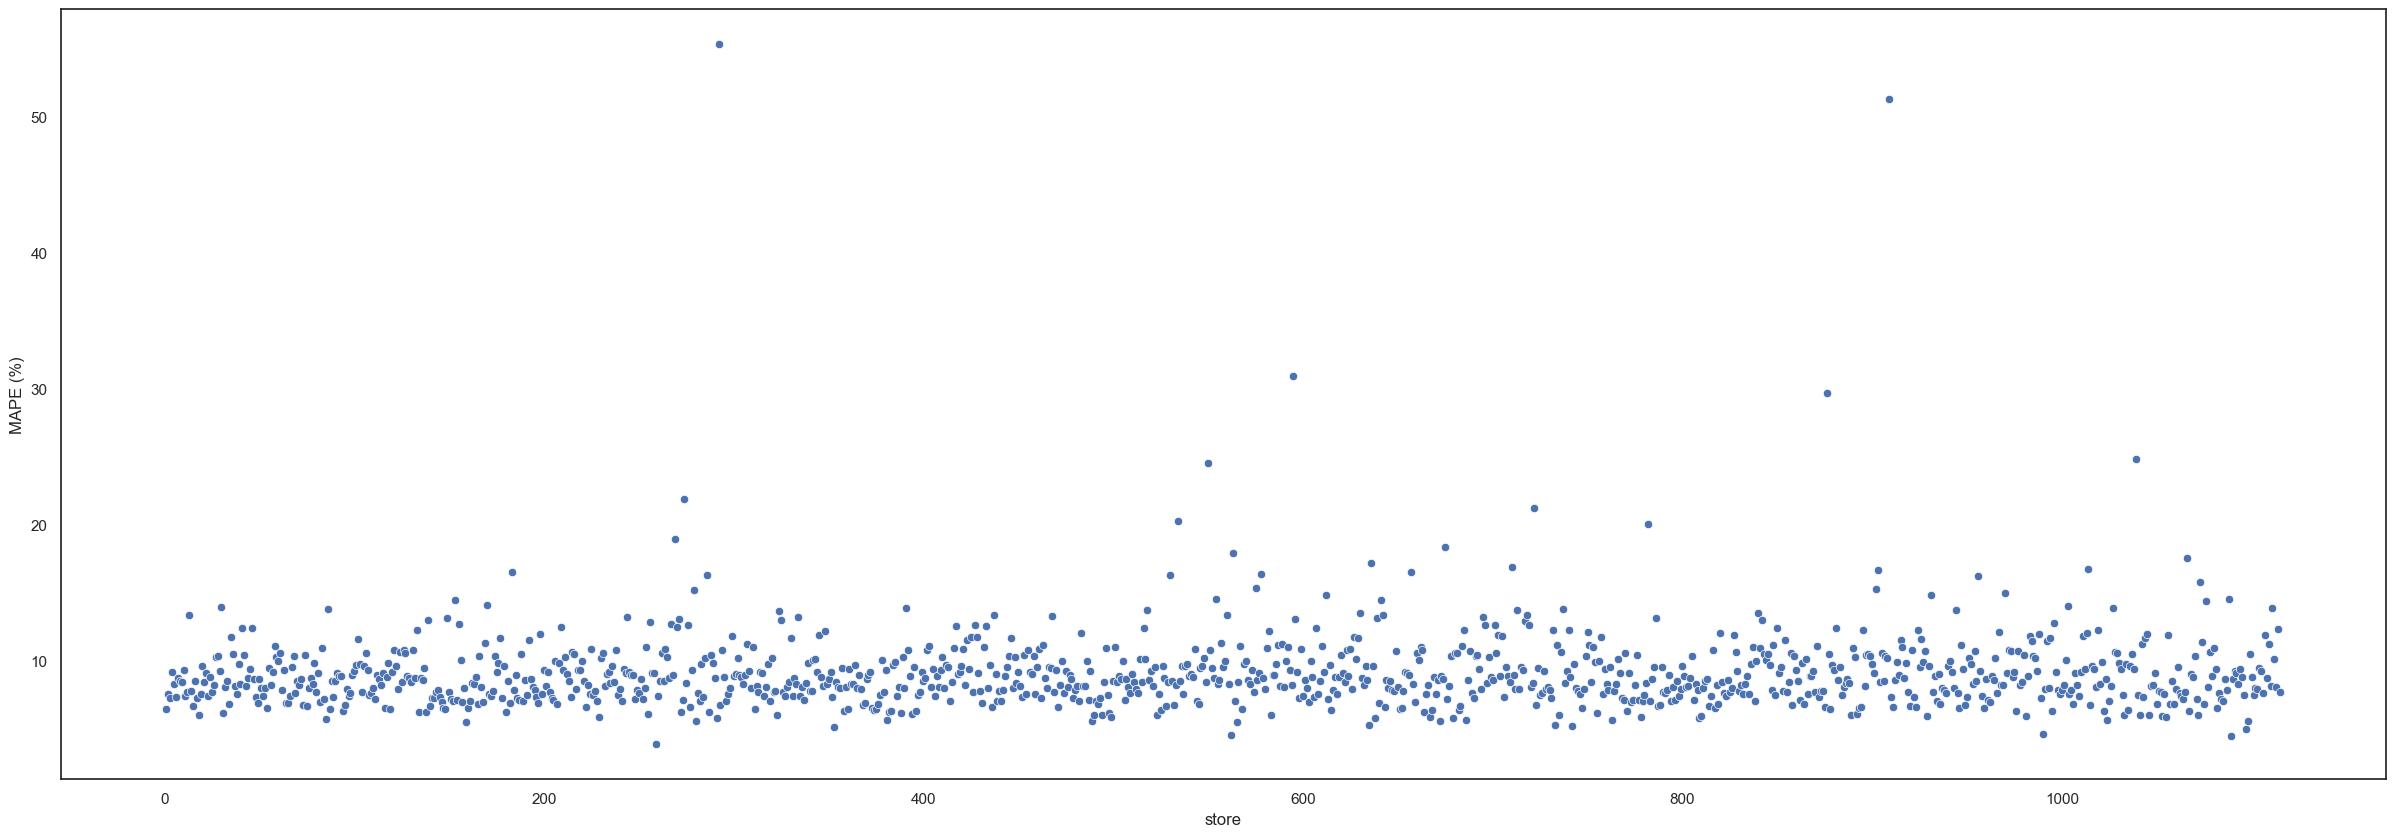

In [136]:
plt.figure(figsize=(30, 10))

sns.scatterplot(x='store', y='MAPE (%)', data=sales_report)

In [137]:
profit_from_sales_report = df10_report[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenarios', 0:'Values'})
profit_from_sales_report['Values'] =  profit_from_sales_report['Values'].map('${:,.2f}'.format)
profit_from_sales_report

,Scenarios,Values
0,predictions,"$282,825,984.00"
1,worst_scenario,"$282,117,748.66"
2,best_scenario,"$283,534,252.87"


## 10.2. Total Performance

In [138]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['sales']

## 10.3. Machine Learning Performance

Text(0.5, 1.0, 'Scatter Plot: Predictions vs Error')

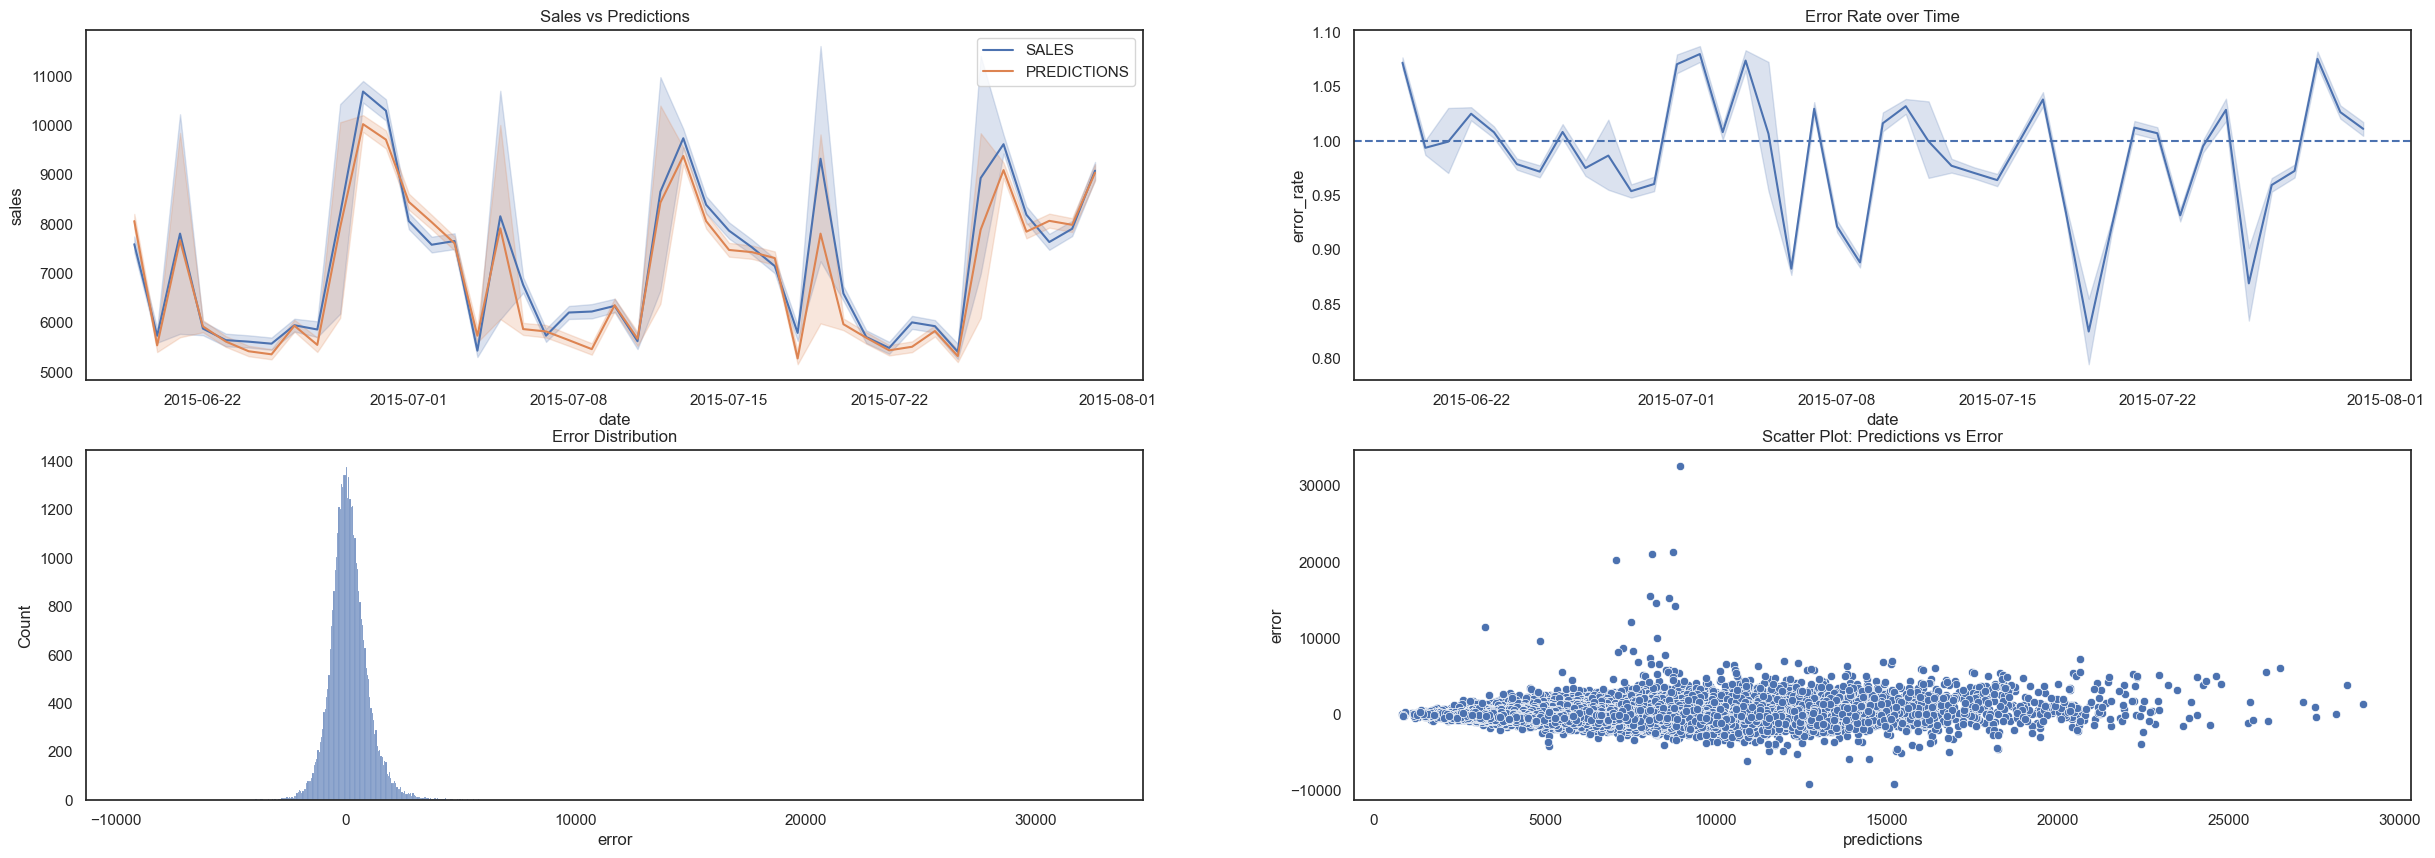

In [139]:
plt.figure(figsize=(30, 10))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df10, label='SALES')
sns.lineplot(x='date', y='predictions', data=df10, label='PREDICTIONS')
plt.title('Sales vs Predictions')
plt.legend()


plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df10)
plt.axhline(1, linestyle='--')
plt.title('Error Rate over Time')

plt.subplot(2, 2, 3)
sns.histplot(x='error', data=df10)
plt.title('Error Distribution')

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df10)
plt.title('Scatter Plot: Predictions vs Error')
